- Lokalde çalışma süresinin artması nedeniyle genetik kodları notebook'a aktarılmıştır.
- Kullanılan veriler sp500.py ve fetchData.py çalışma sonuçlarından alınmıştır. Düzenlenmiş veridir.

# Gerekli Kütüphanelerin Yüklenmesi

In [1]:
!pip install bayesian-optimization
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 16.6 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd
from scipy.stats import dirichlet
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from bayes_opt import BayesianOptimization
import os
import warnings
warnings.filterwarnings('ignore')

# Verilerin Okunması ve Train-Test Olarak Ayrılması

In [8]:
stock_data = pd.read_csv('stock_data.csv', index_col='Date', parse_dates=True)
tickers = stock_data.columns.tolist()
num_assets = len(tickers)

In [9]:
start_date = "2023-01-01"
end_date   = "2025-01-01"

start = pd.to_datetime(start_date)
end = pd.to_datetime(end_date)
total_days = (end - start).days
train_end = start + pd.Timedelta(days=int(total_days * 0.8))

train_end_date = train_end.strftime("%Y-%m-%d")
test_start_date = (train_end + pd.Timedelta(days=1)).strftime("%Y-%m-%d")

print("Train set: {} to {}".format(start_date, train_end_date))
print("Test set: {} to {}".format(test_start_date, end_date))

Train set: 2023-01-01 to 2024-08-07
Test set: 2024-08-08 to 2025-01-01


In [10]:
df = pd.read_csv("stock_data.csv", parse_dates=["Date"])

train = df[(df["Date"] >= "2023-01-01") & (df["Date"] <= "2024-08-07")]
test = df[(df["Date"] >= "2024-08-08") & (df["Date"] <= "2025-01-01")]

print("Train Set Boyutu:", train.shape)
print("Test Set Boyutu:", test.shape)

Train Set Boyutu: (401, 24)
Test Set Boyutu: (101, 24)


In [11]:
train.index = train["Date"]
train = train.drop("Date", axis=1)
test.index = test["Date"]
test = test.drop("Date", axis=1)

In [12]:
returns = np.log(stock_data/stock_data.shift(1)).dropna()
expected_returns = returns.mean().values
cov_matrix = returns.cov().values

returns_train = np.log(train/train.shift(1)).dropna()
expected_returns_train = returns_train.mean().values
cov_matrix_train = returns_train.cov().values
corr_matrix_train = returns_train.corr().values

returns_test = np.log(test/test.shift(1)).dropna()
expected_returns_test = returns_test.mean().values
cov_matrix_test = returns_test.cov().values
corr_matrix_test = returns_test.corr().values

# Verilerin Analiz Edilmesi

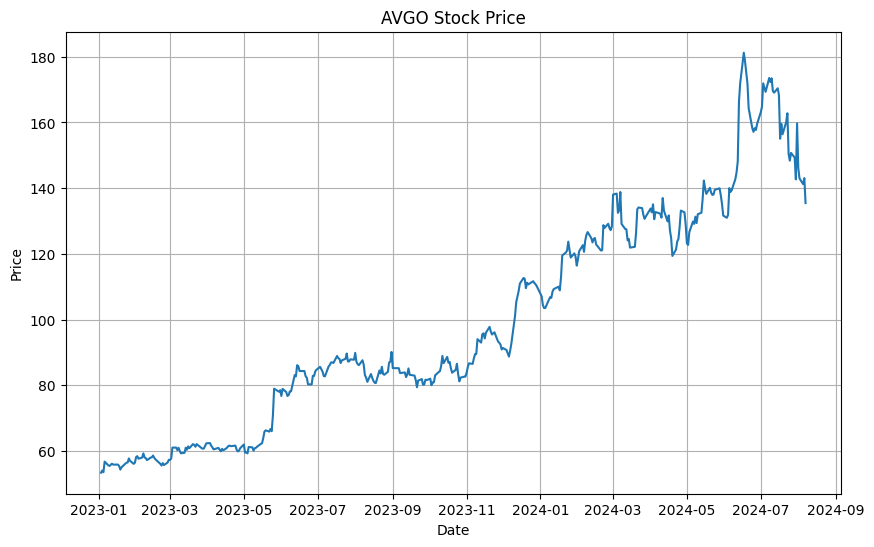

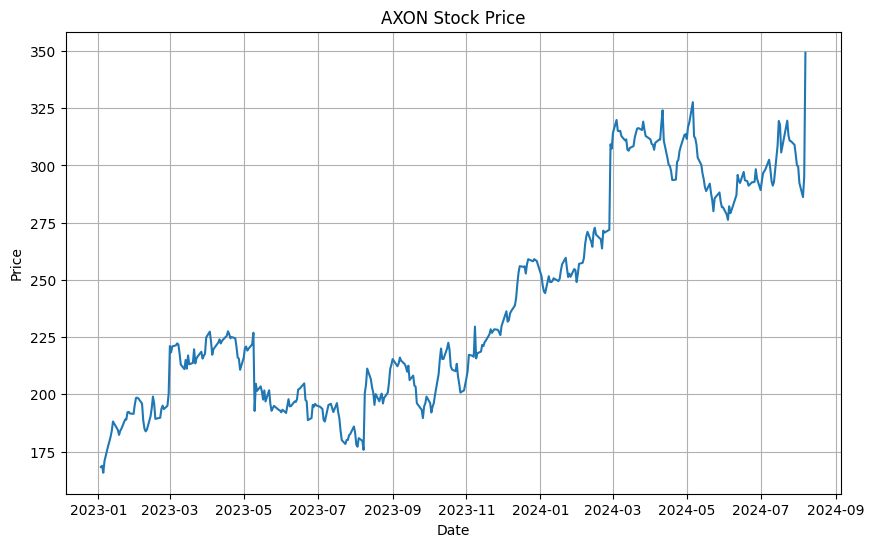

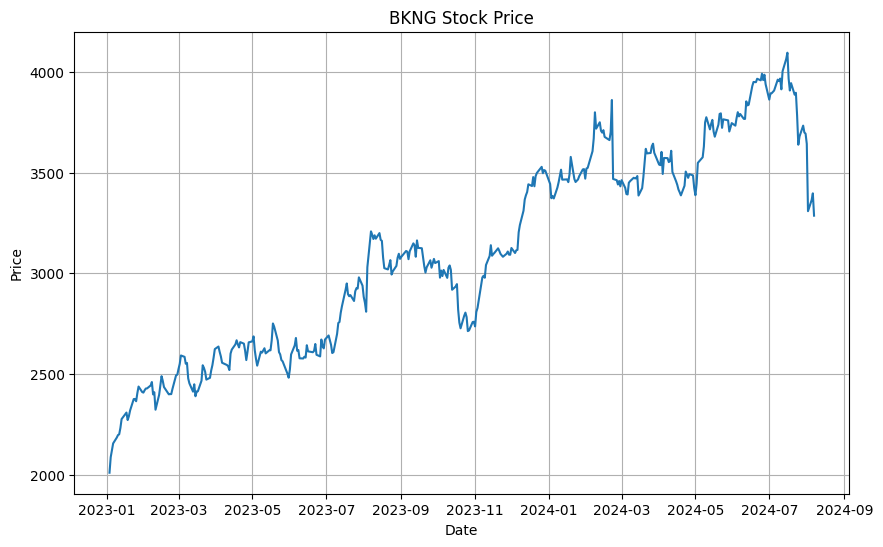

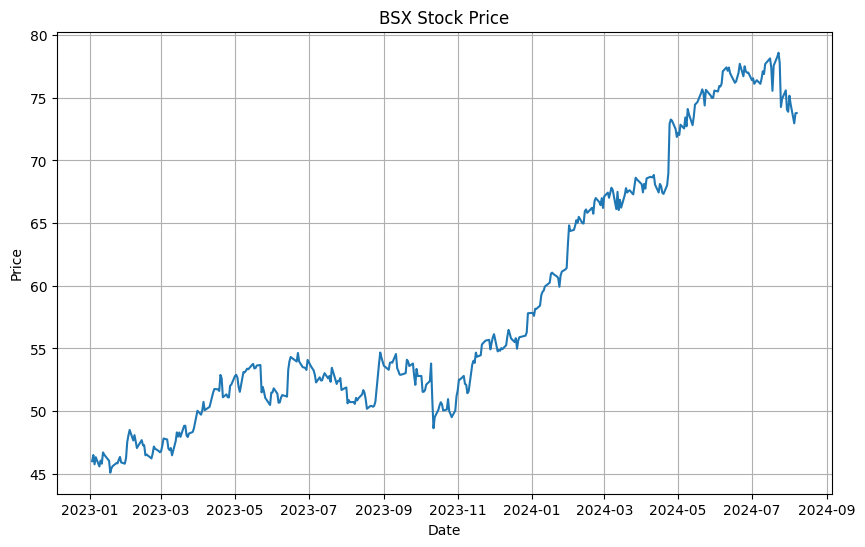

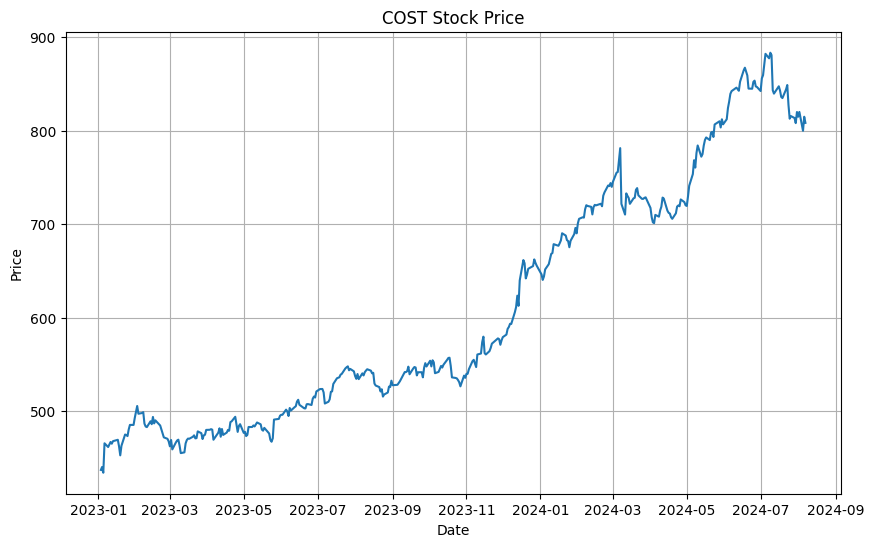

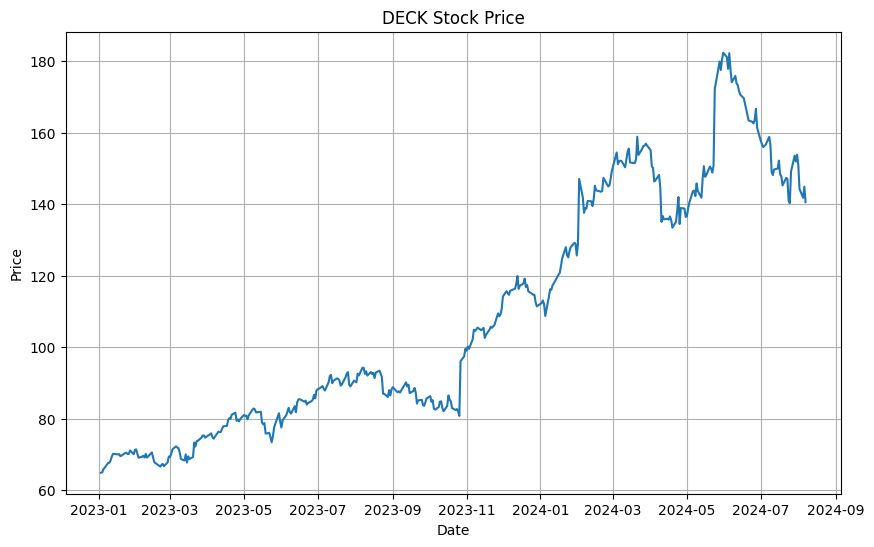

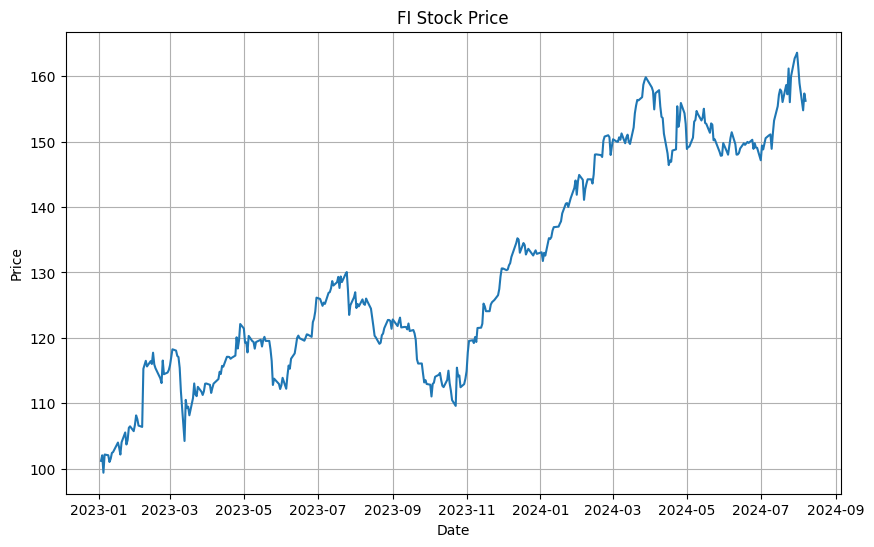

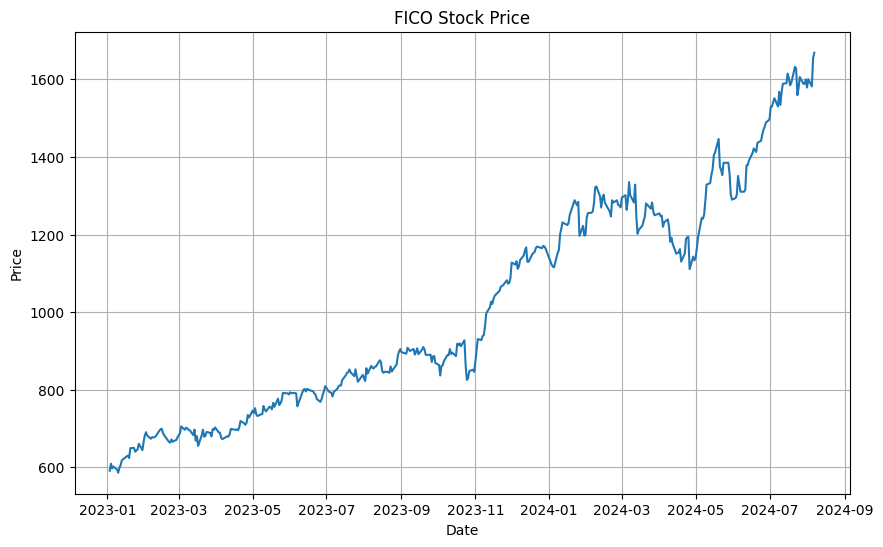

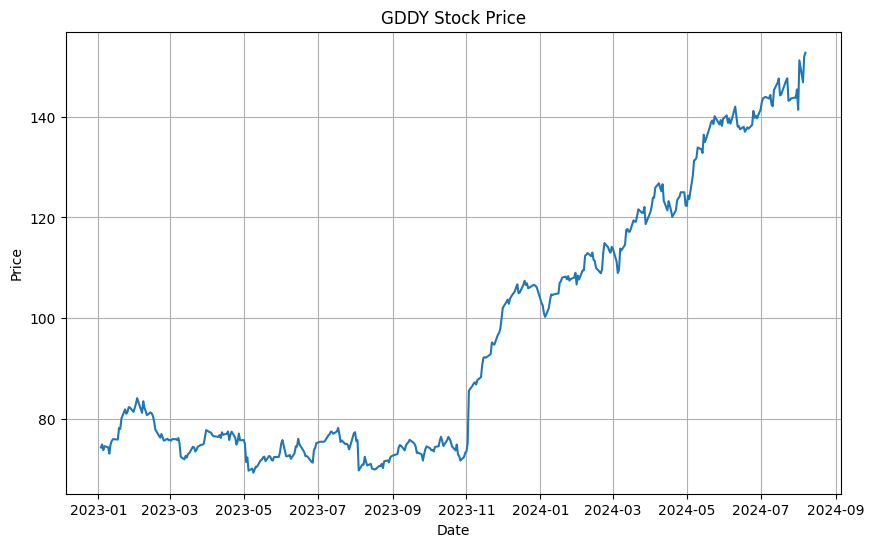

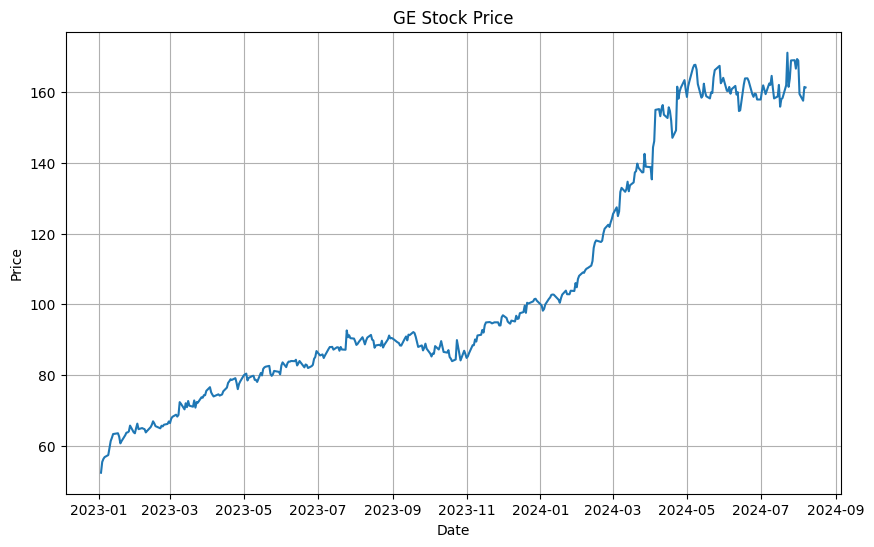

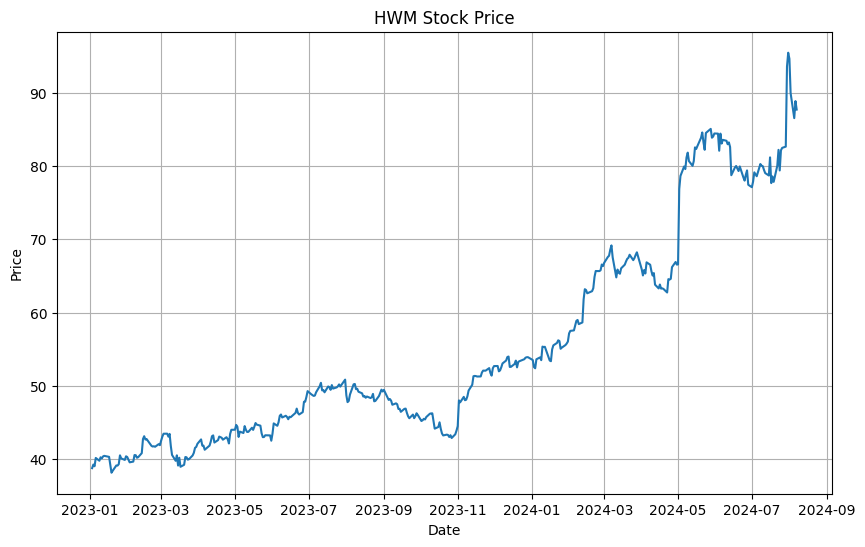

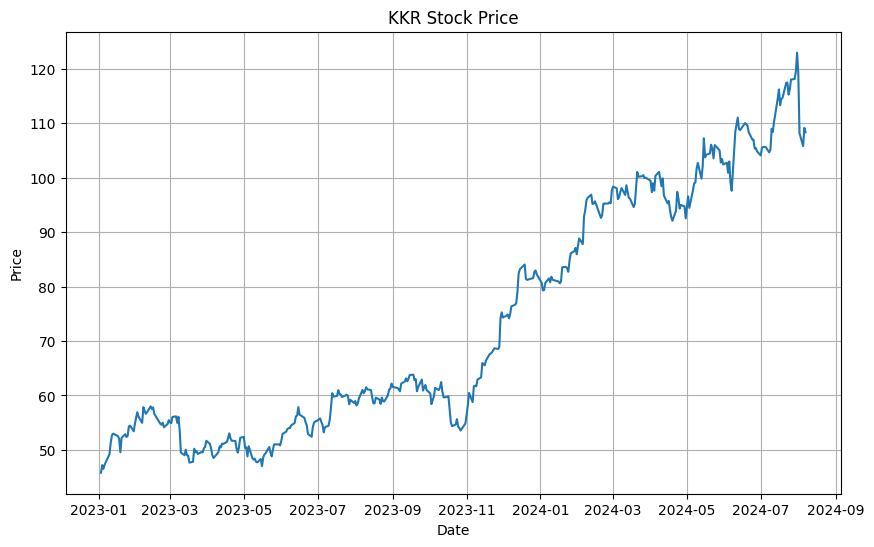

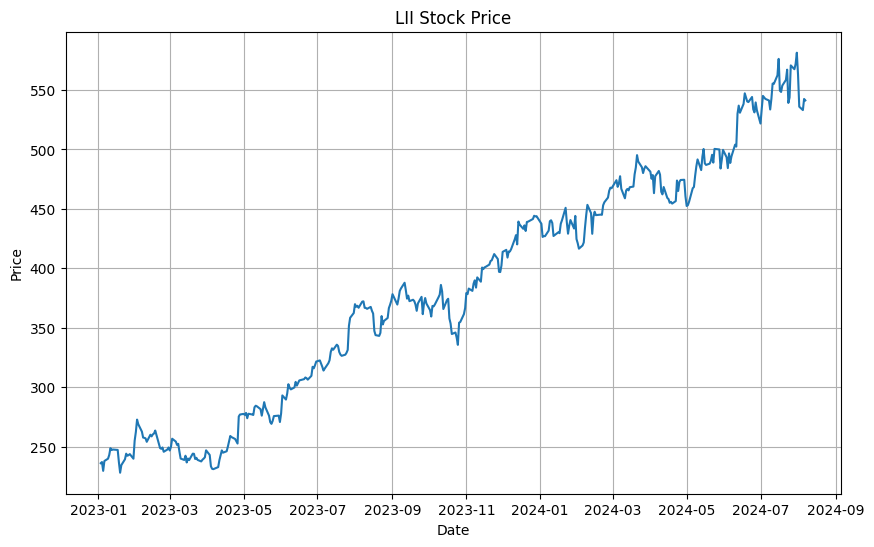

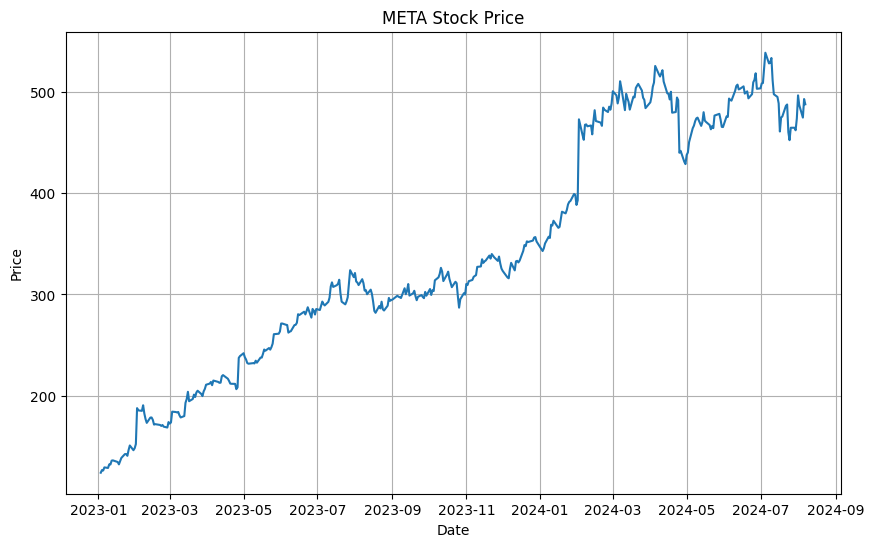

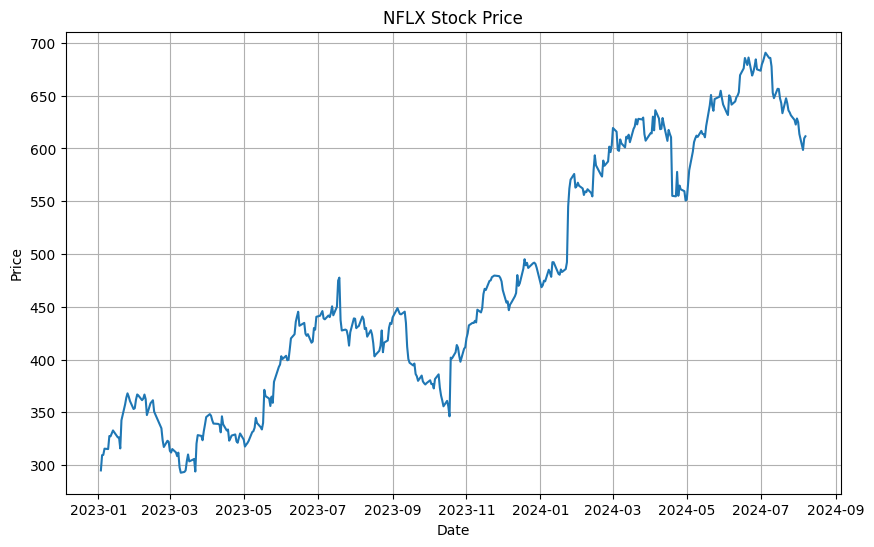

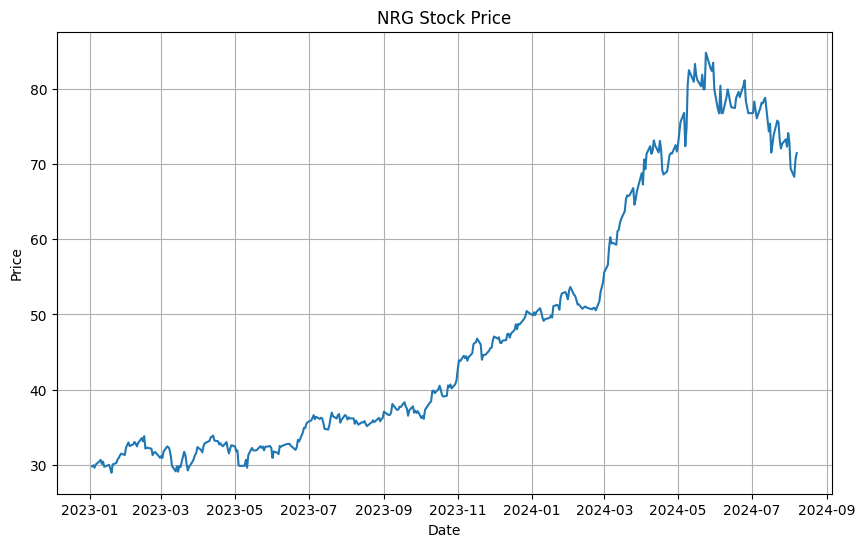

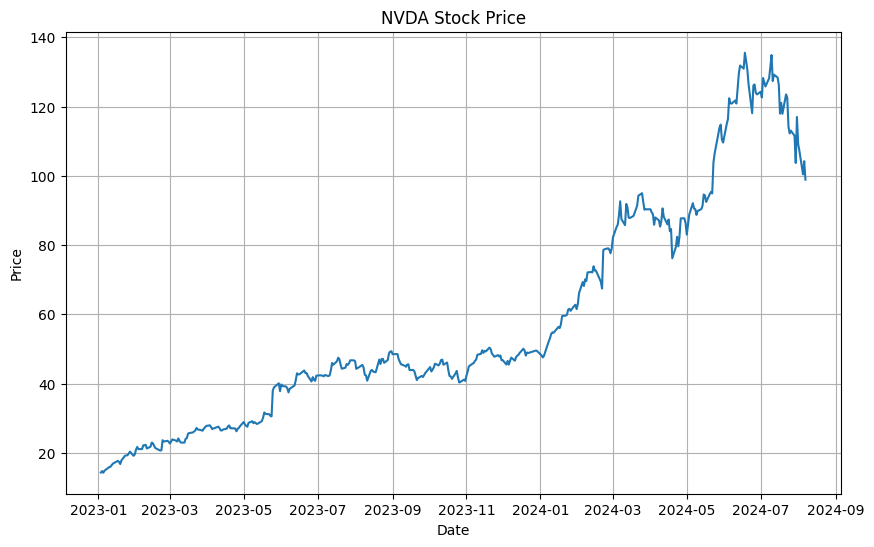

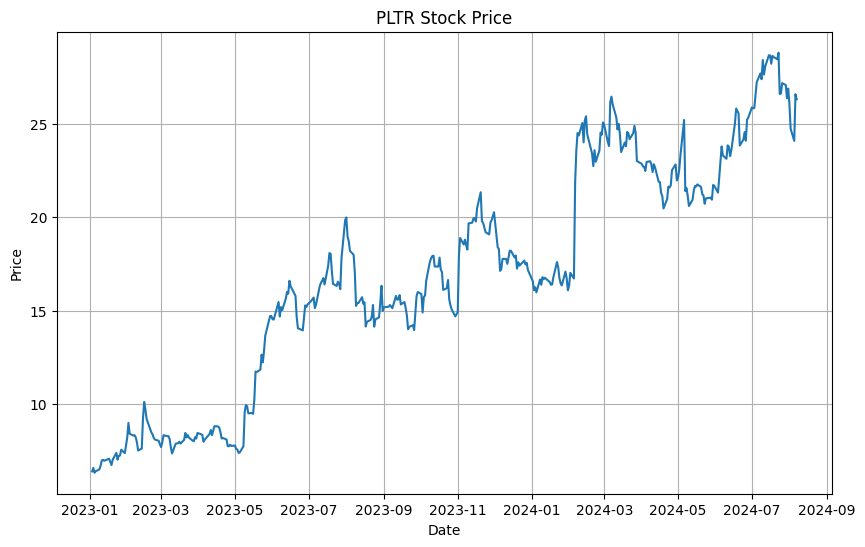

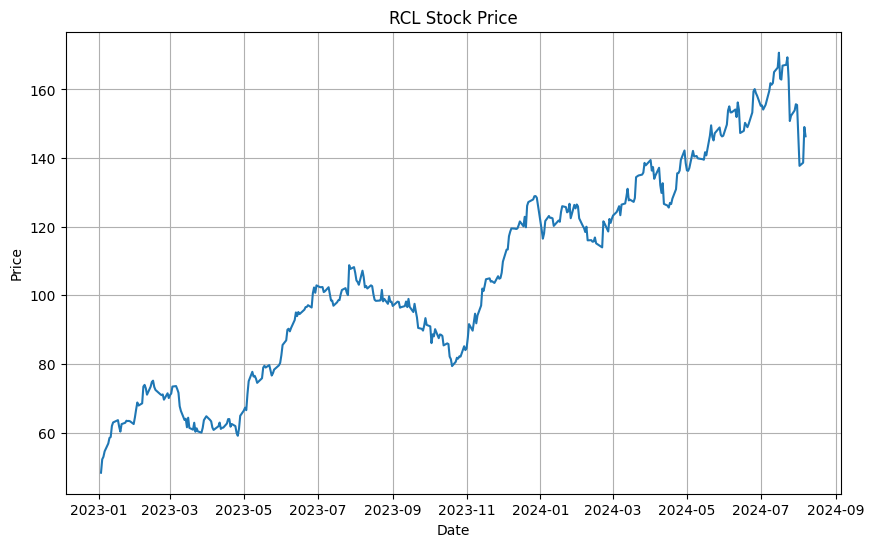

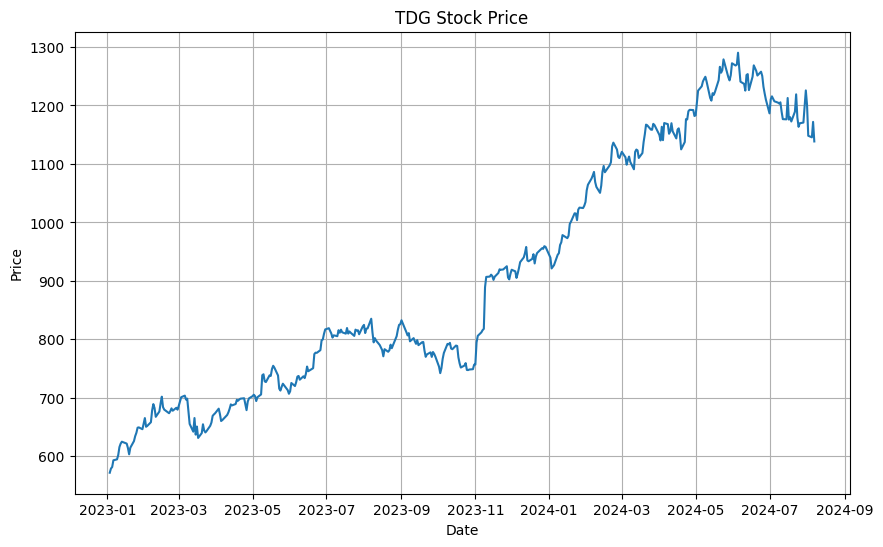

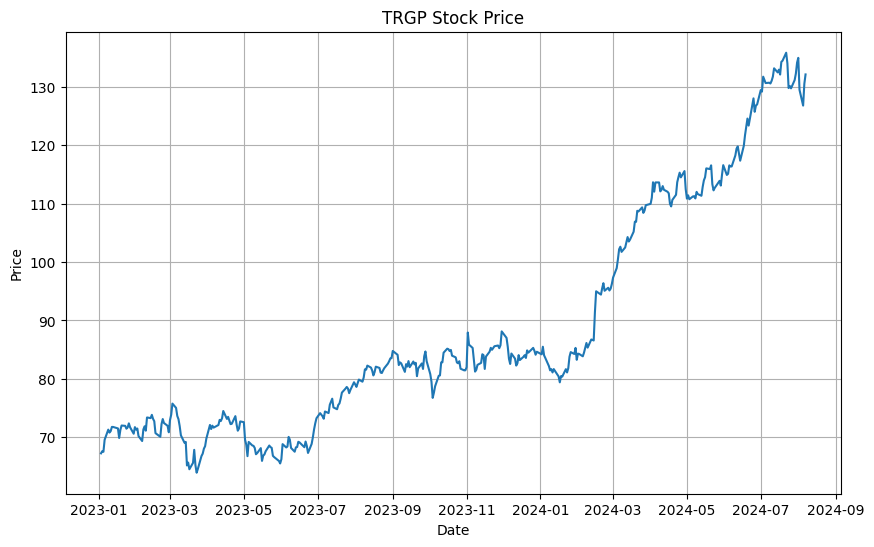

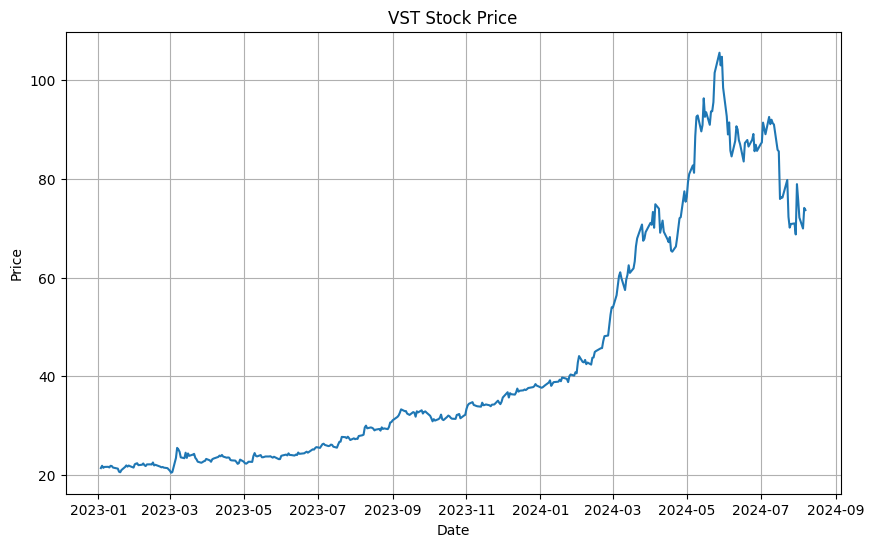

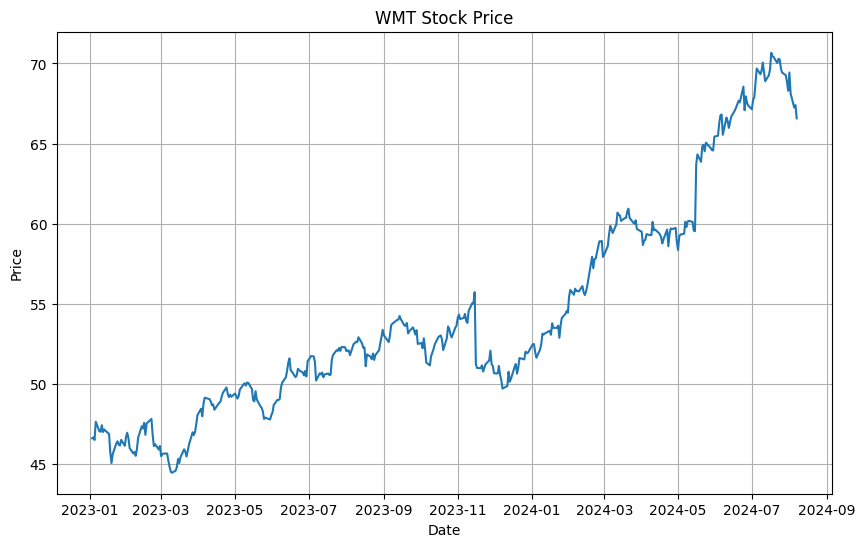

In [ ]:
import matplotlib.pyplot as plt
for ticker in tickers:
  plt.figure(figsize=(10, 6))
  plt.plot(train[ticker])
  plt.title(f'{ticker} Stock Price')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.grid(True)
  plt.show()


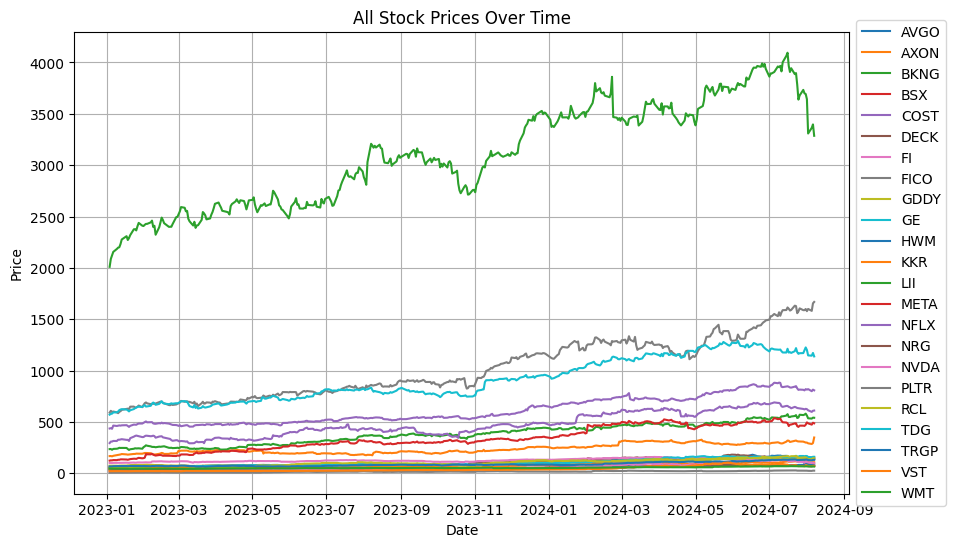

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for ticker in tickers:
    plt.plot(train[ticker], label=ticker)

plt.title('All Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()


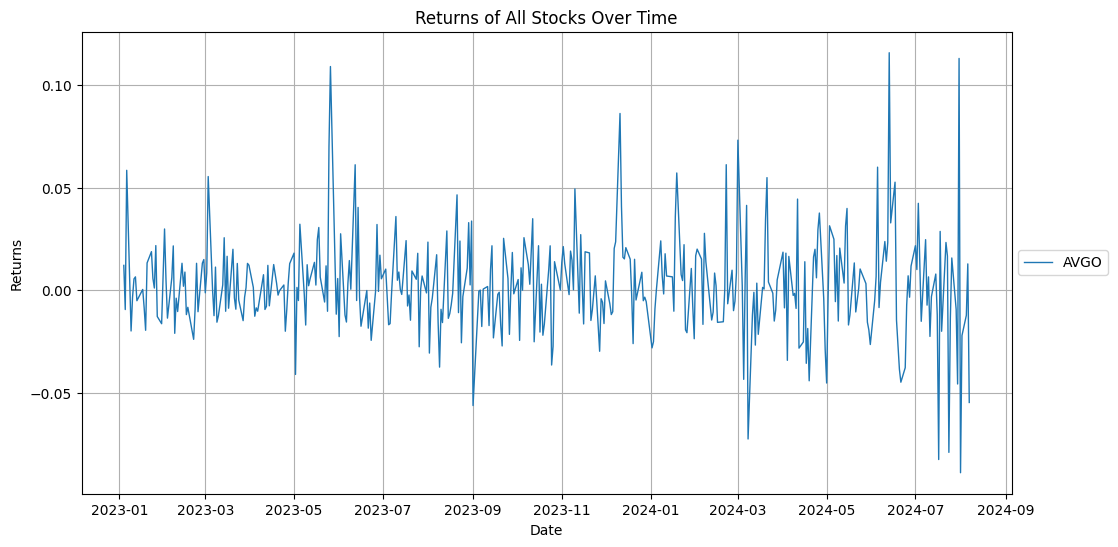

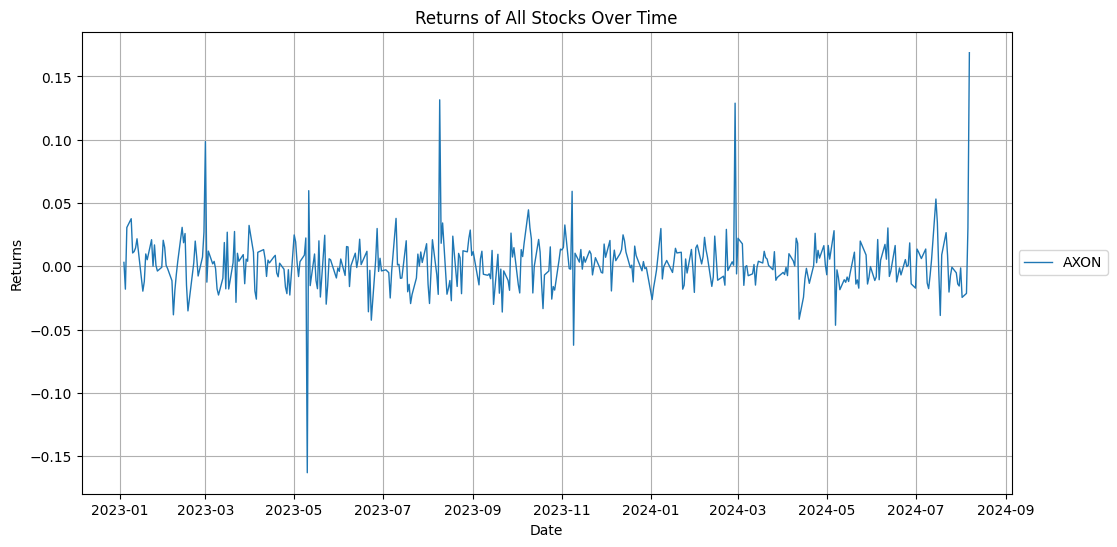

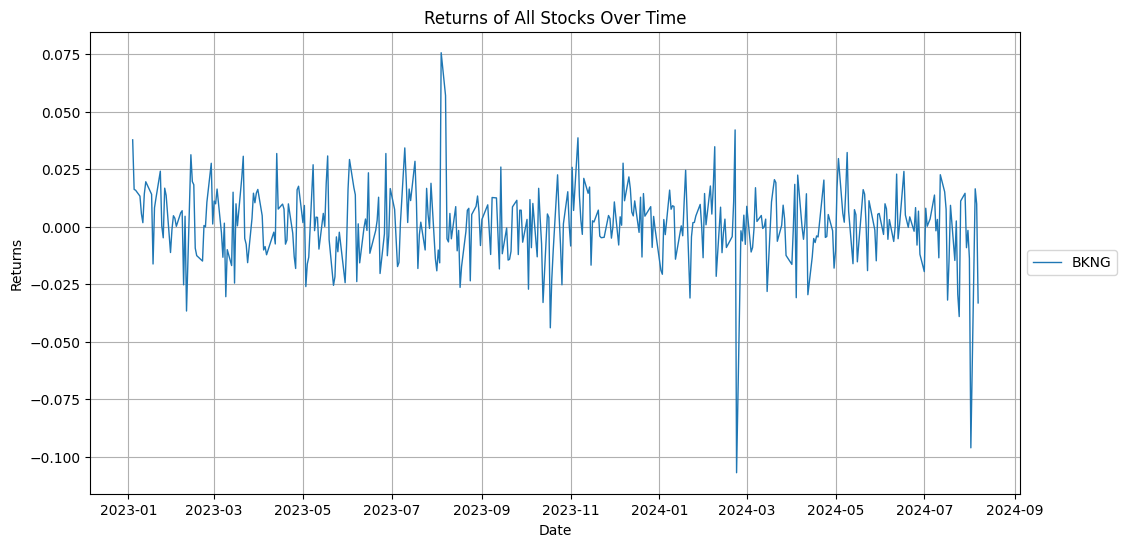

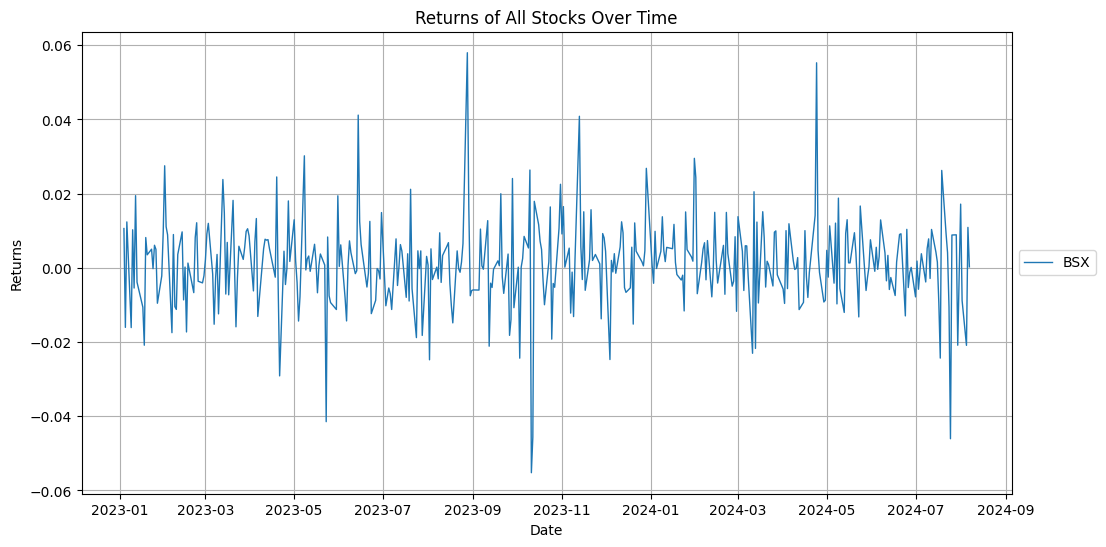

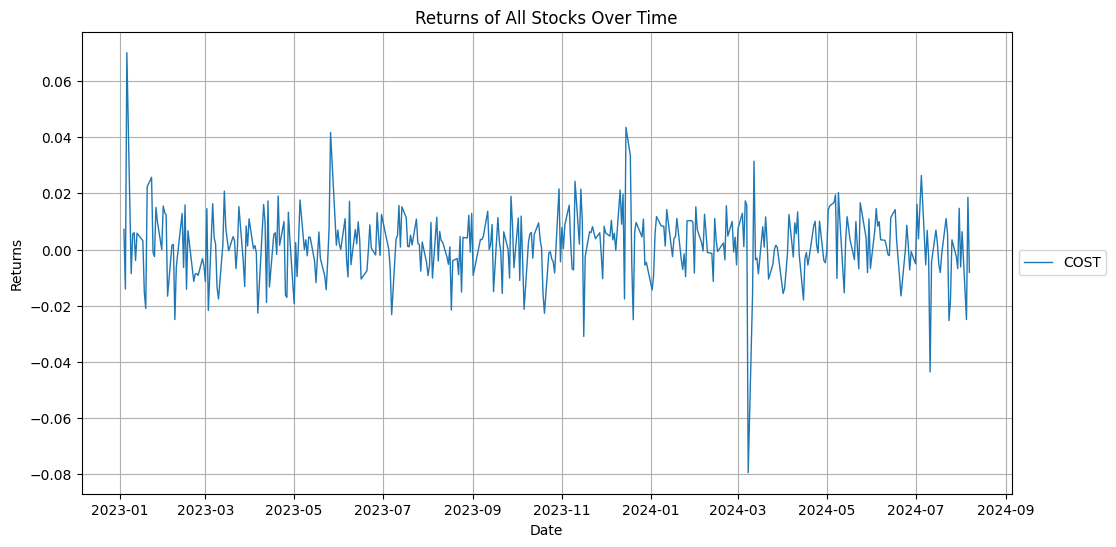

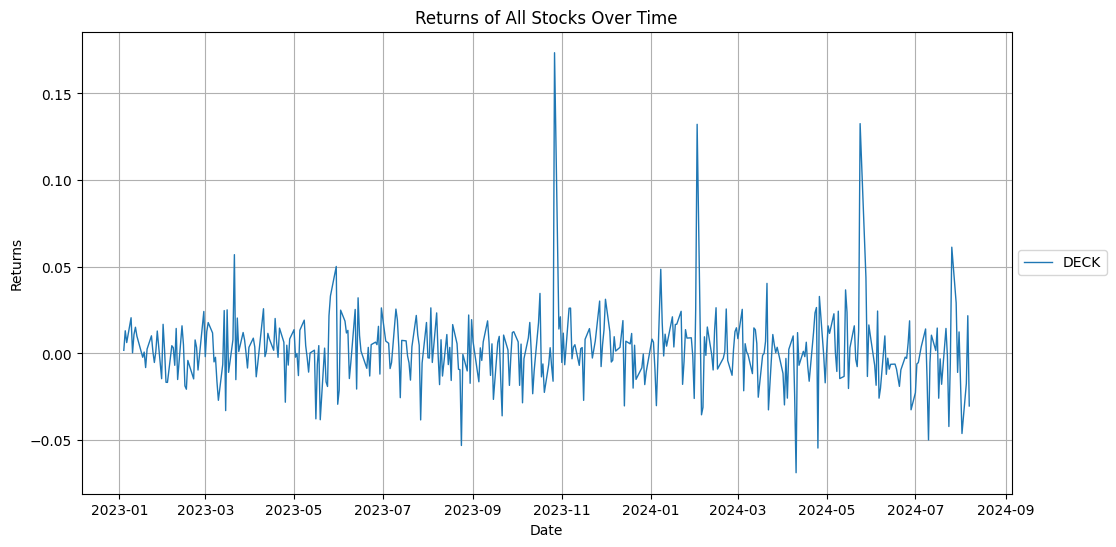

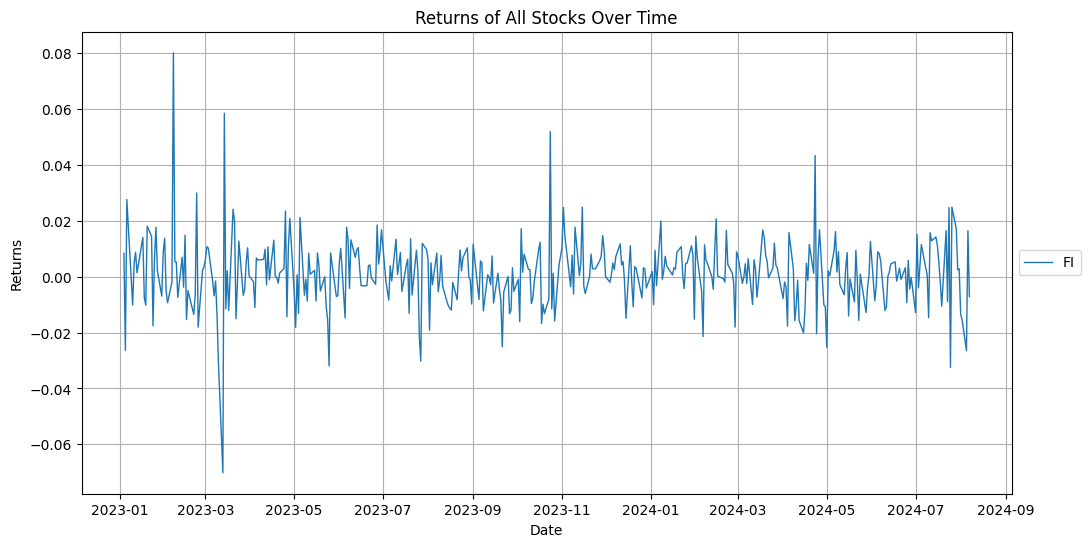

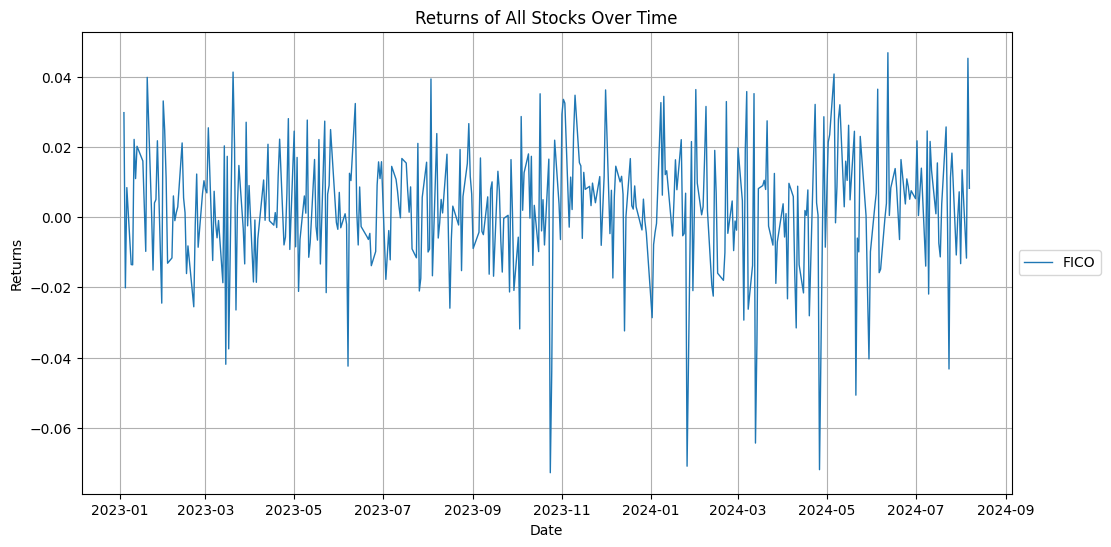

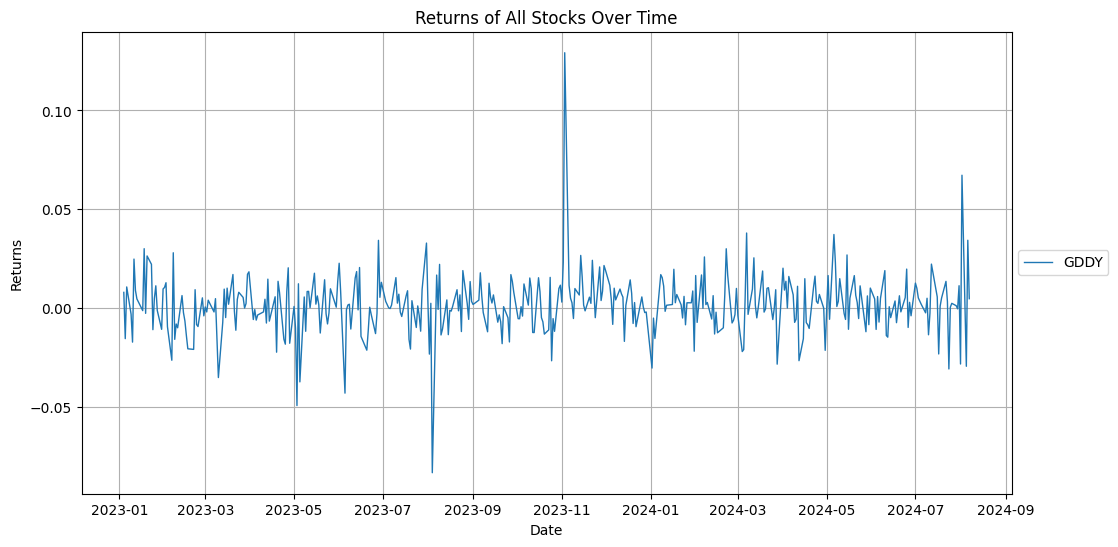

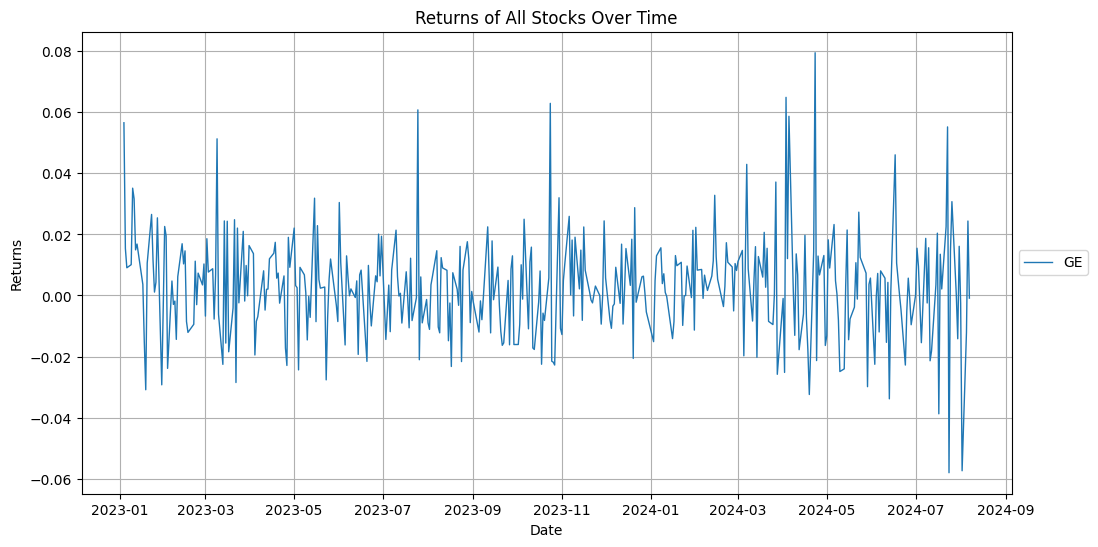

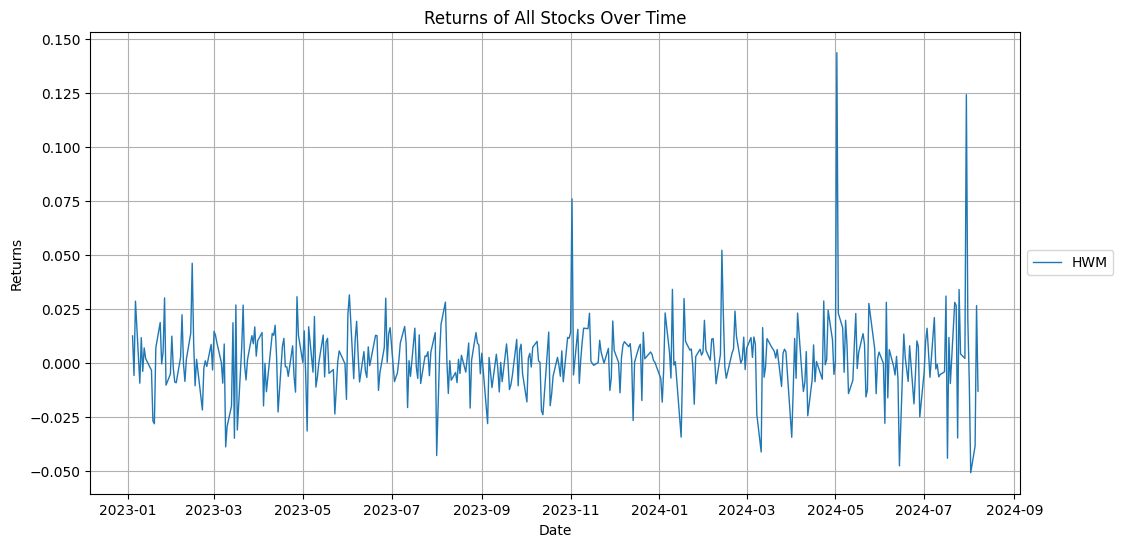

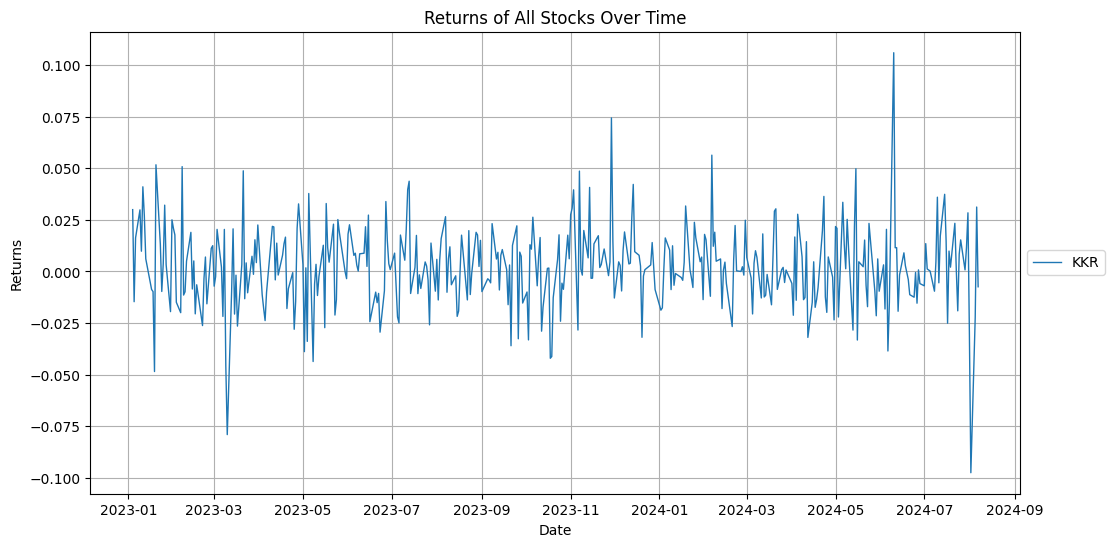

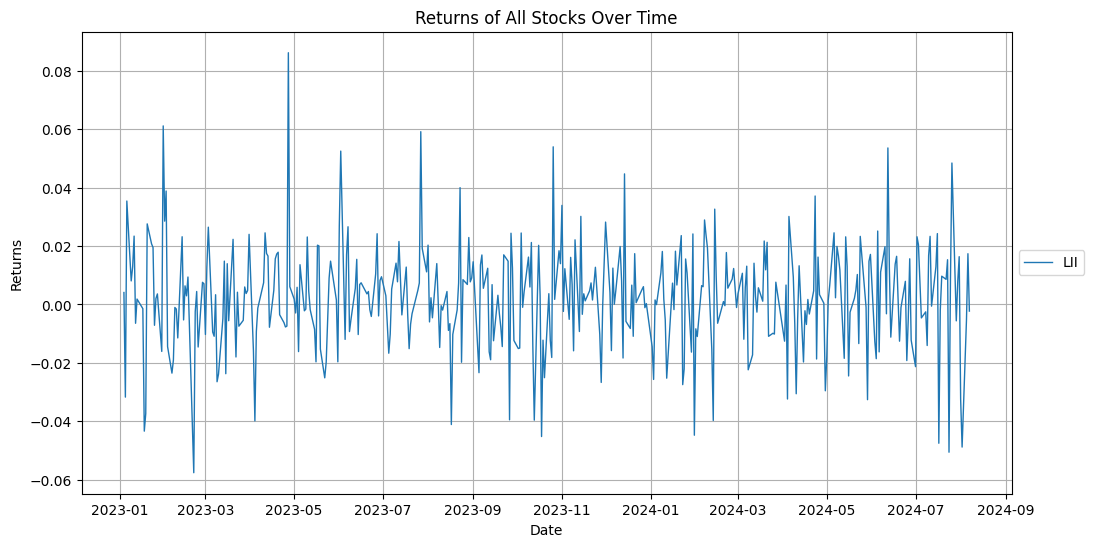

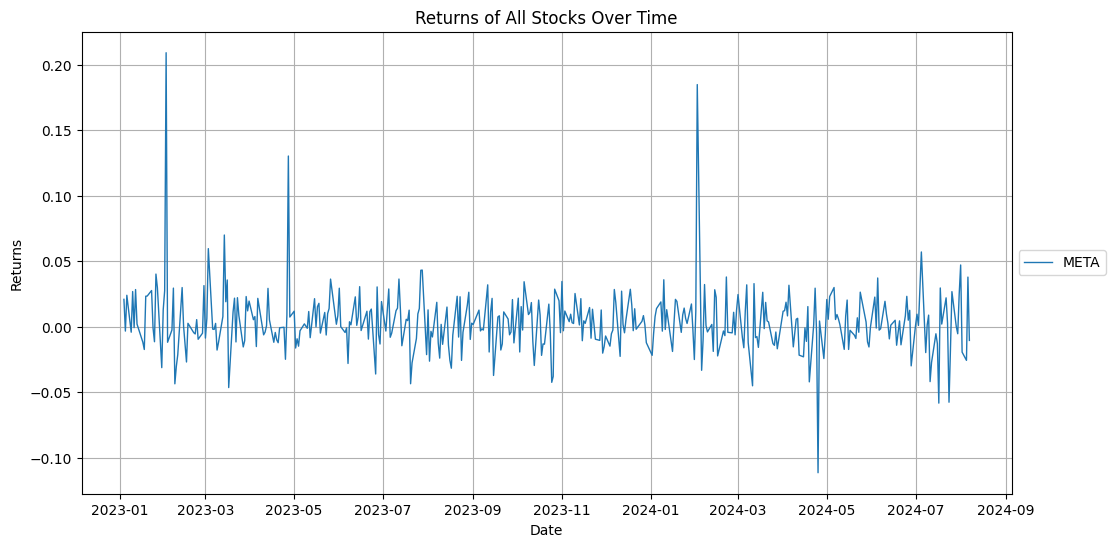

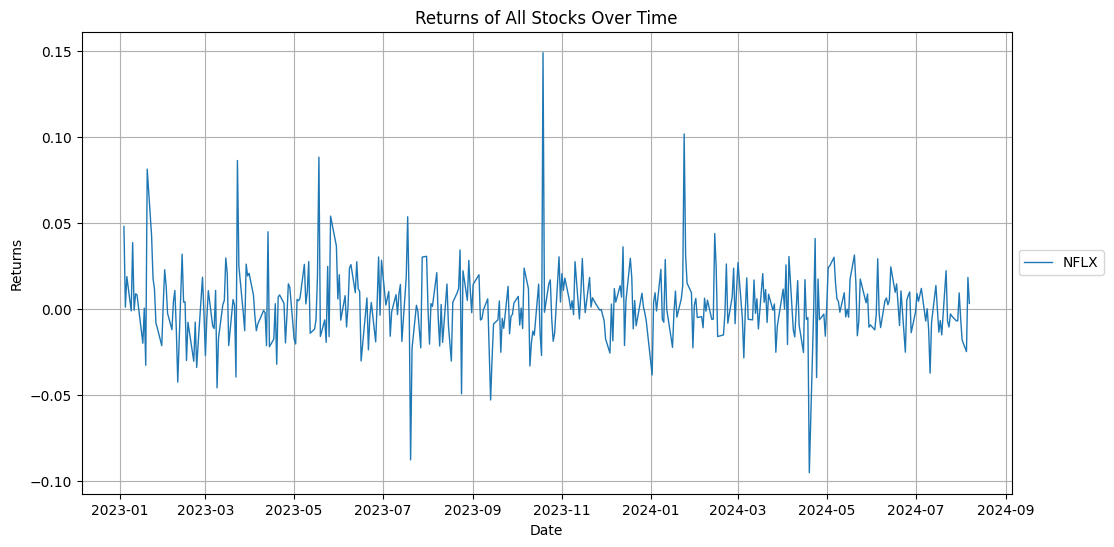

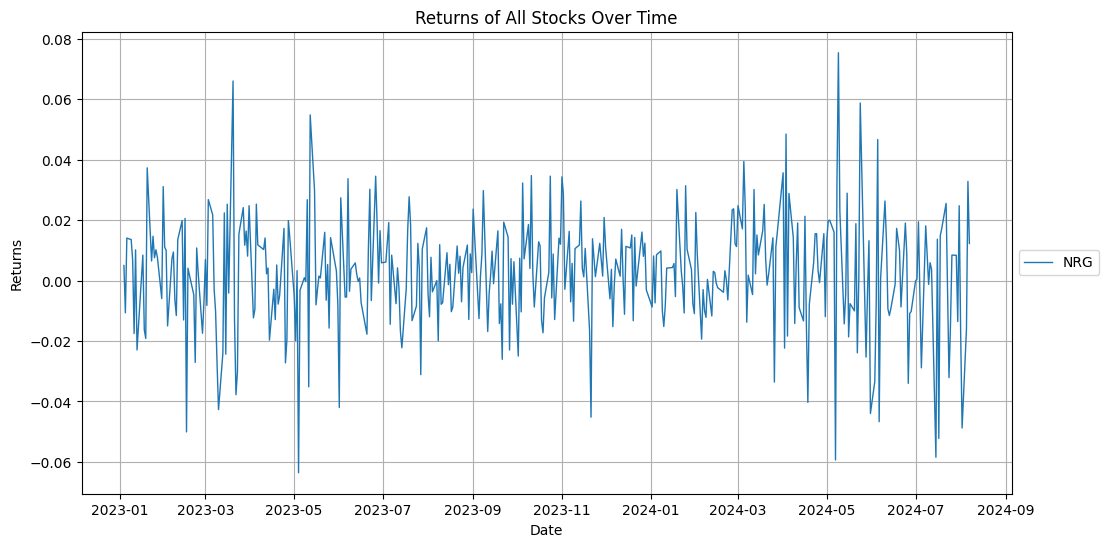

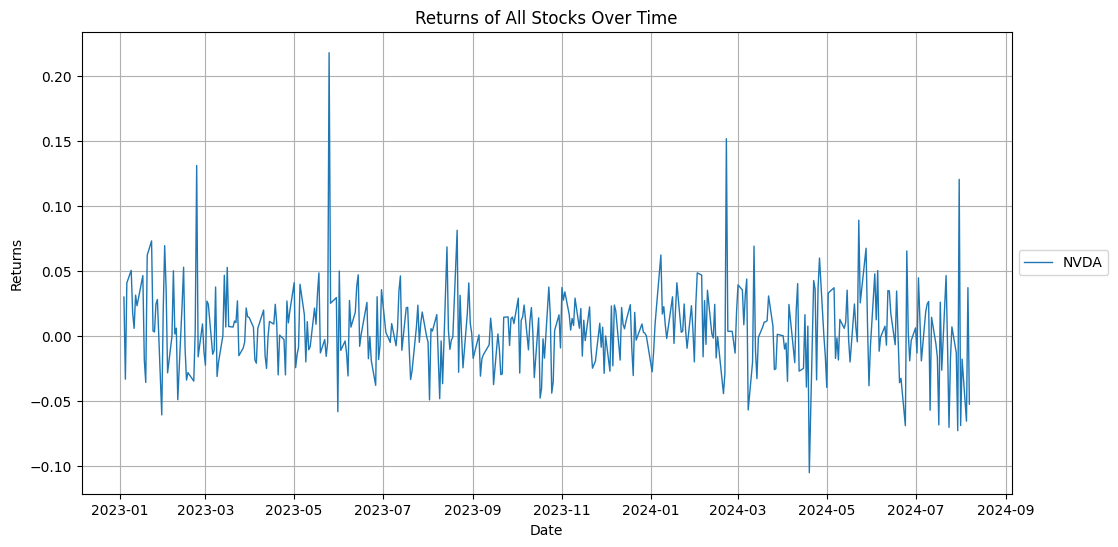

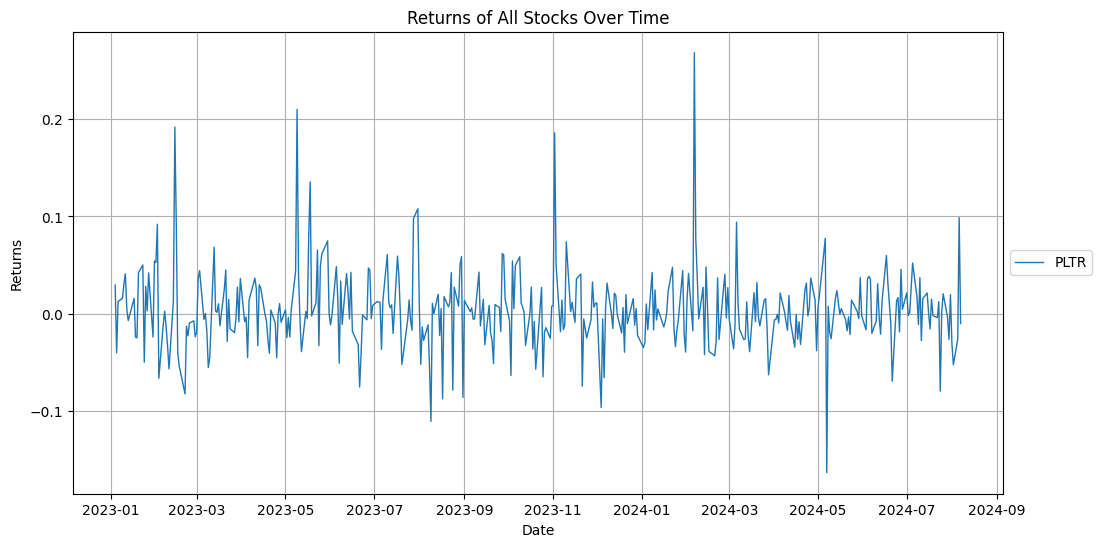

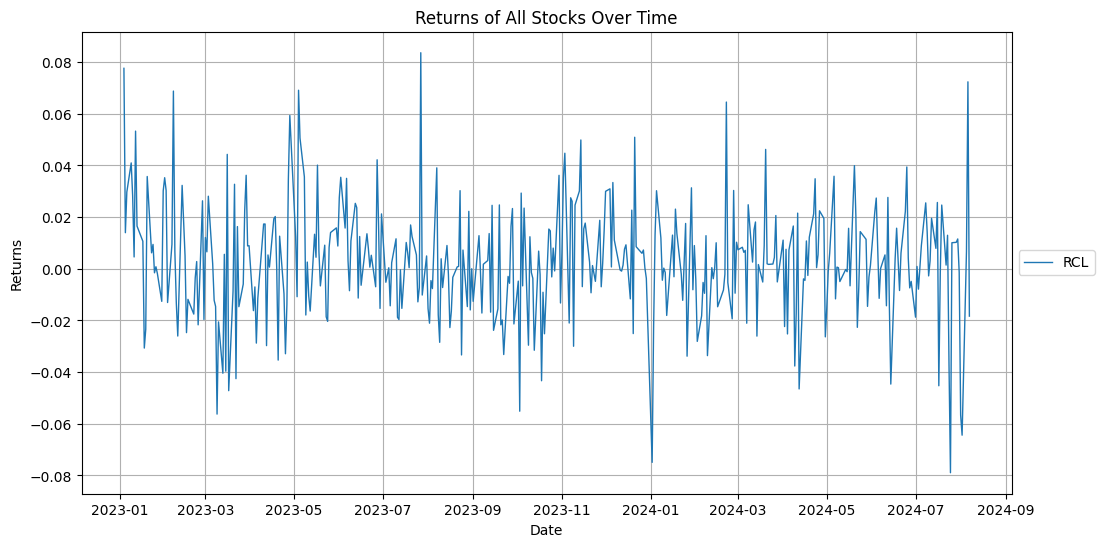

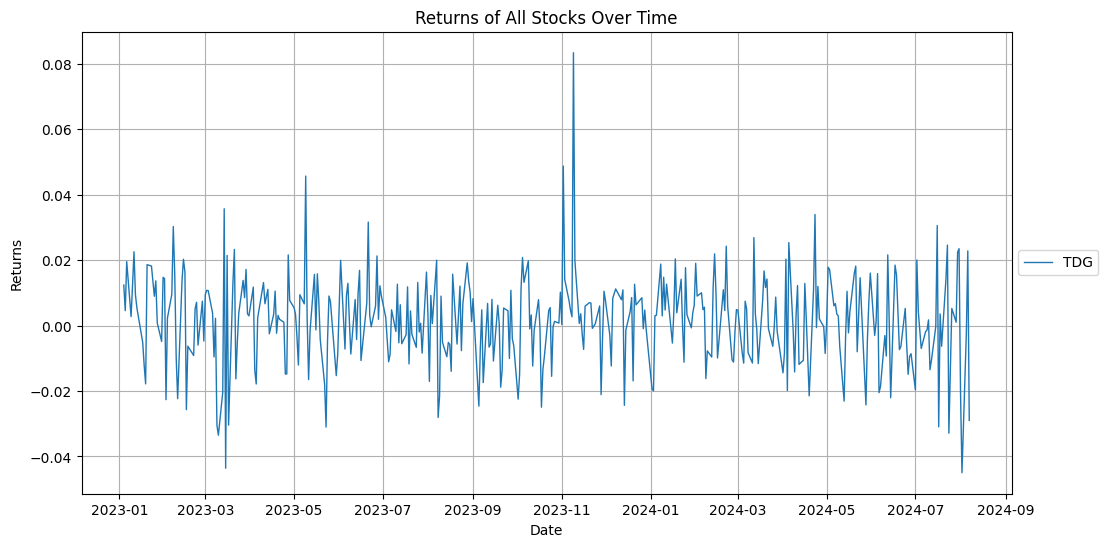

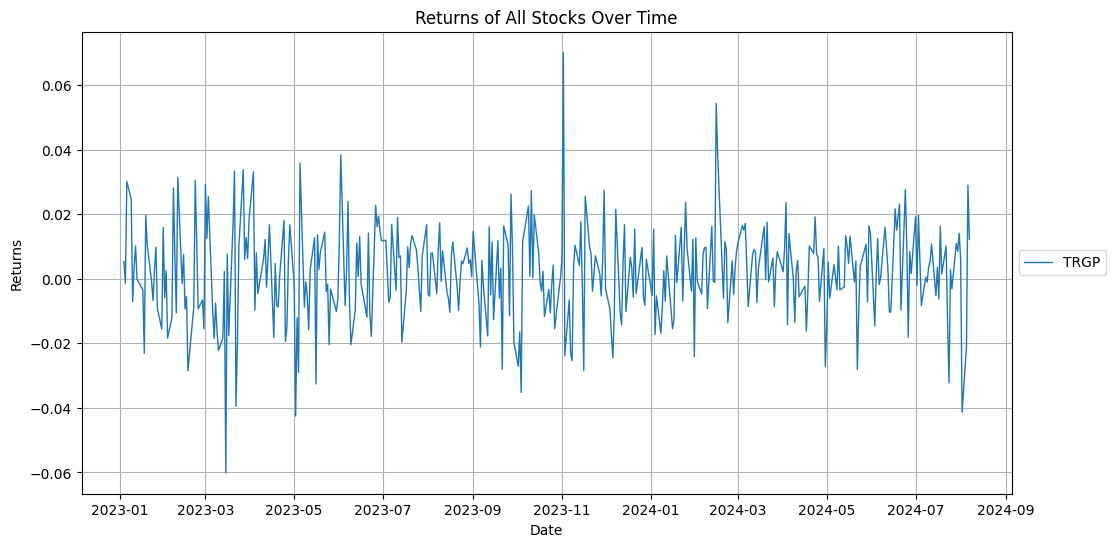

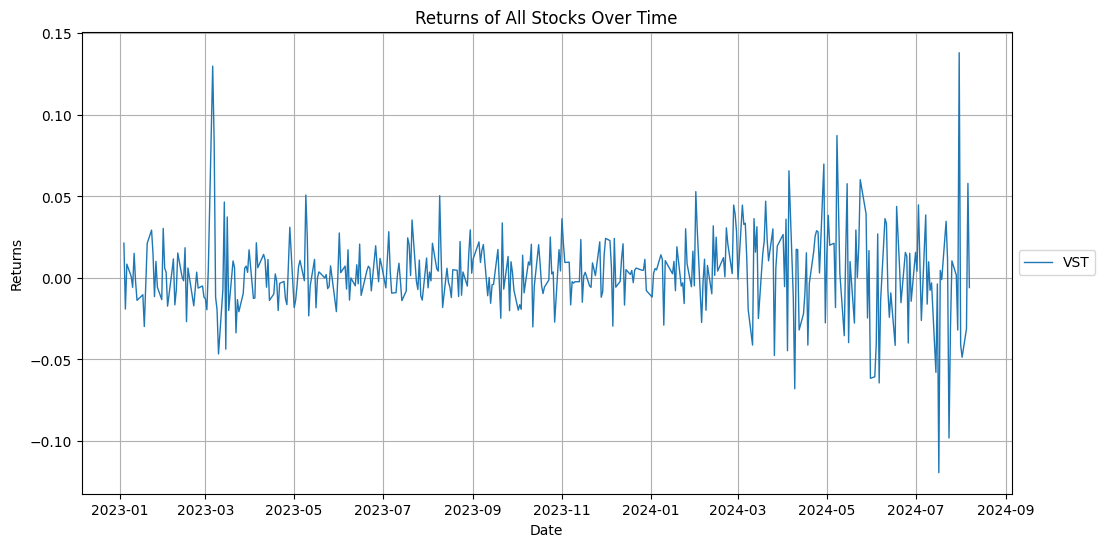

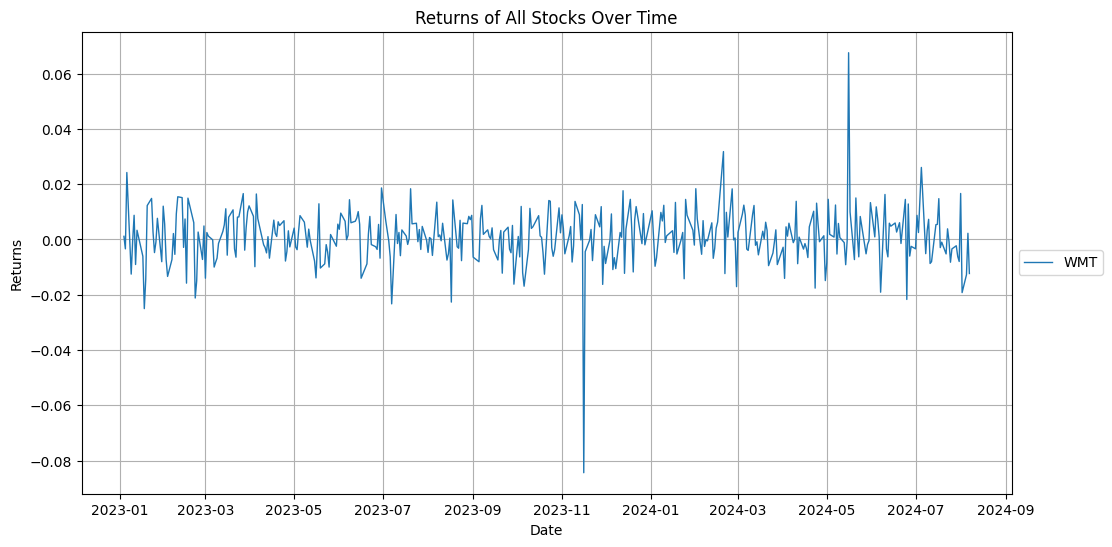

In [ ]:
for i in range(returns_train.shape[1]):
  plt.figure(figsize=(12, 6))
  plt.plot(returns_train.iloc[:, i], label=returns_train.columns[i], linewidth=1)
  plt.title('Returns of All Stocks Over Time')
  plt.xlabel('Date')
  plt.ylabel('Returns')
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.grid(True)
  plt.show()


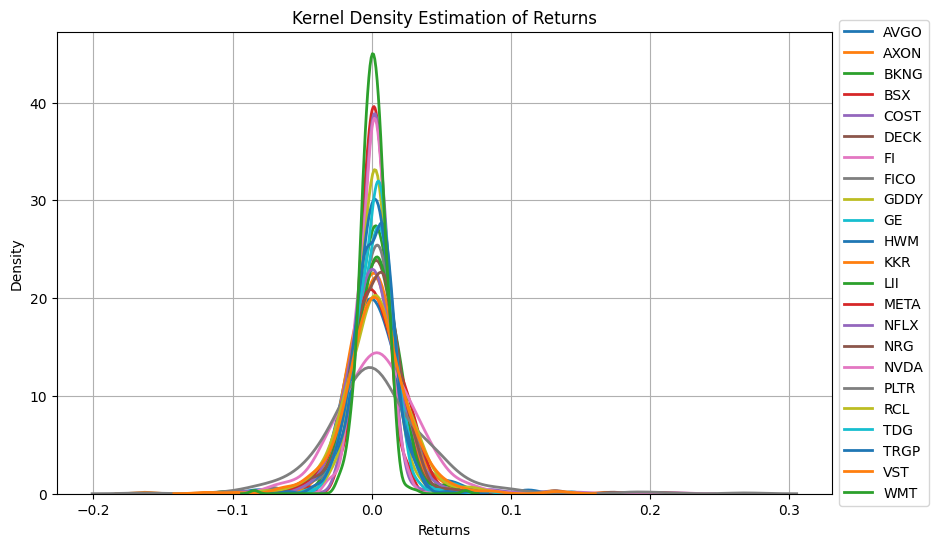

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(returns_train.shape[1]):
  sns.kdeplot(returns_train.iloc[:, i], label=returns_train.columns[i], linewidth=2)
plt.title('Kernel Density Estimation of Returns')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

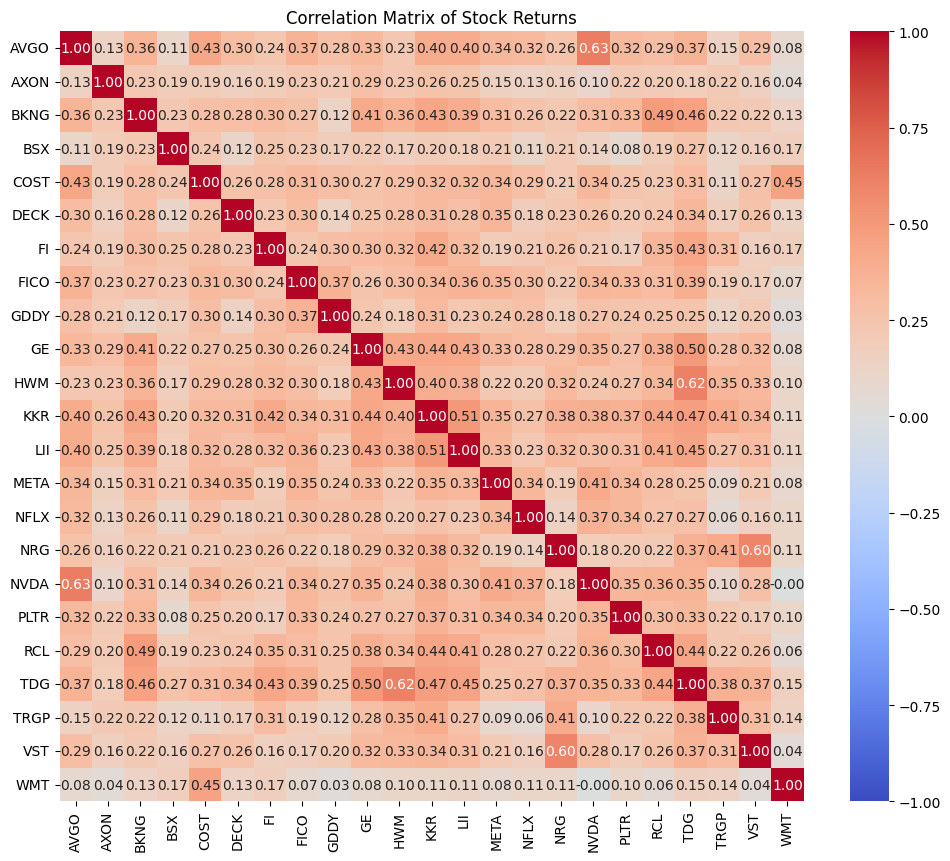

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_train, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, xticklabels=tickers, yticklabels=tickers)
plt.title('Correlation Matrix of Stock Returns')
plt.show()

In [ ]:
def shrinkage(cov_matrix):
  identity_matrix = np.eye(cov_matrix.shape[0])
  lamda = 0.5
  cov_matrix_shrink = lamda * identity_matrix + (1 - lamda) * cov_matrix
  cov_matrix = cov_matrix_shrink
  return cov_matrix

# Log Return Dağılımlarının İncelenmesi

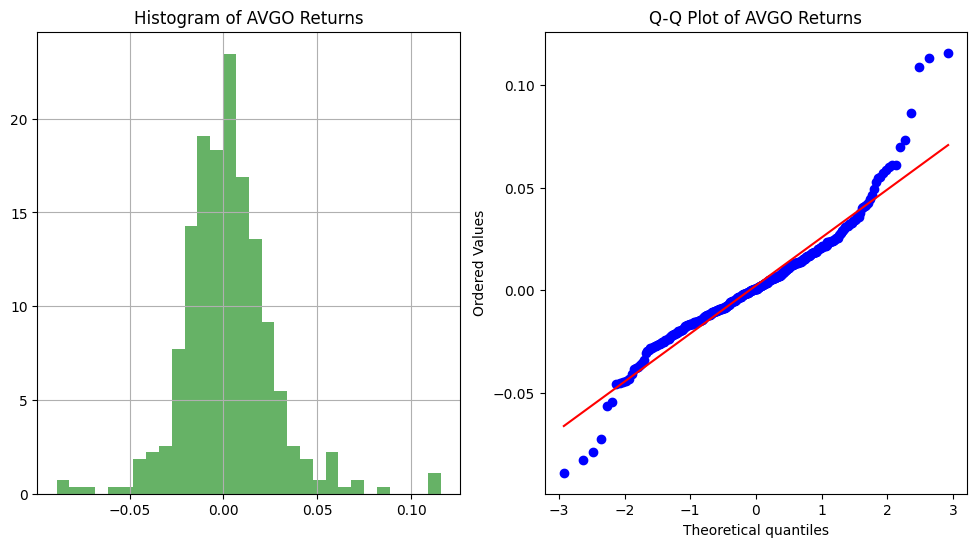

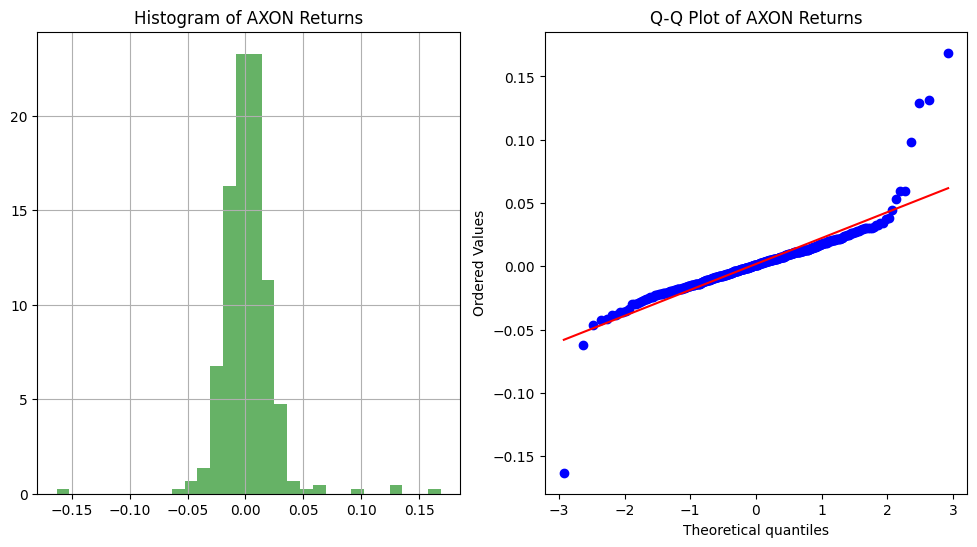

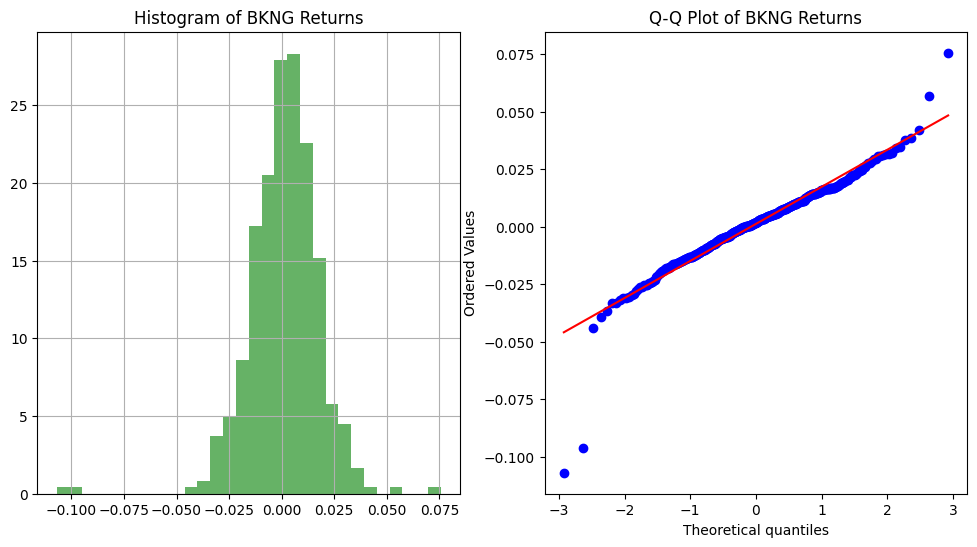

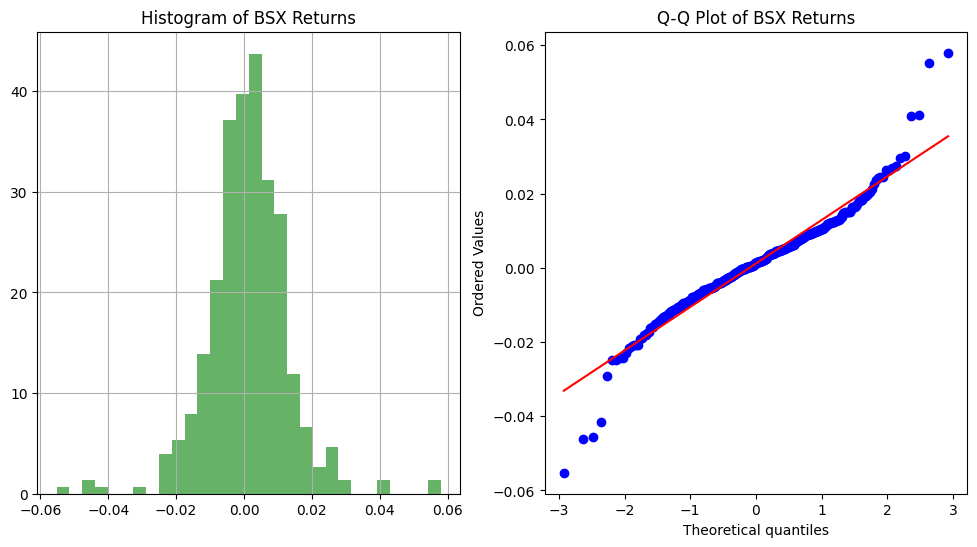

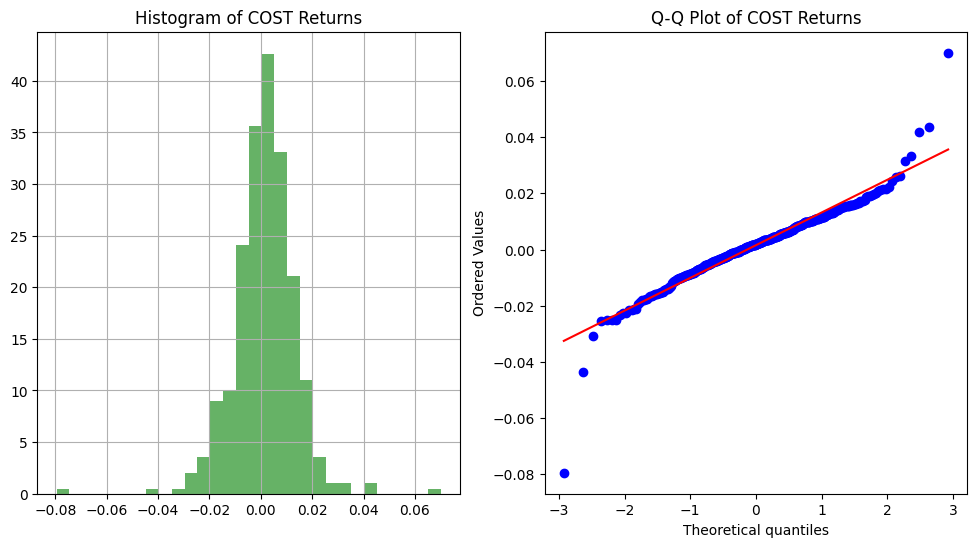

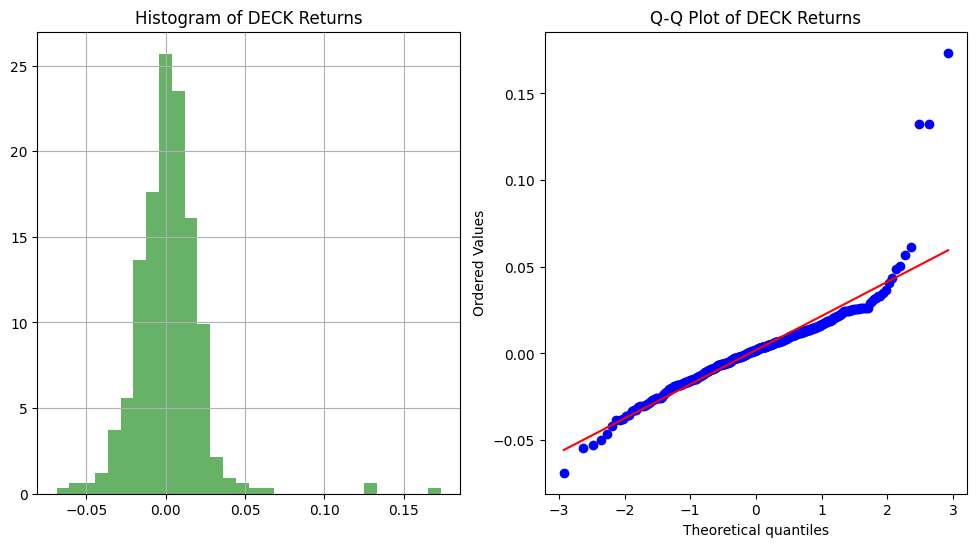

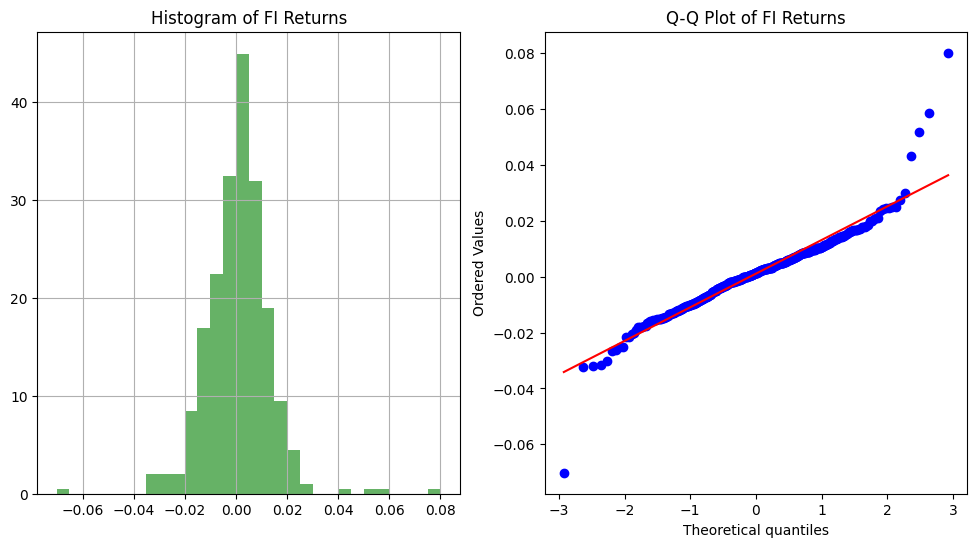

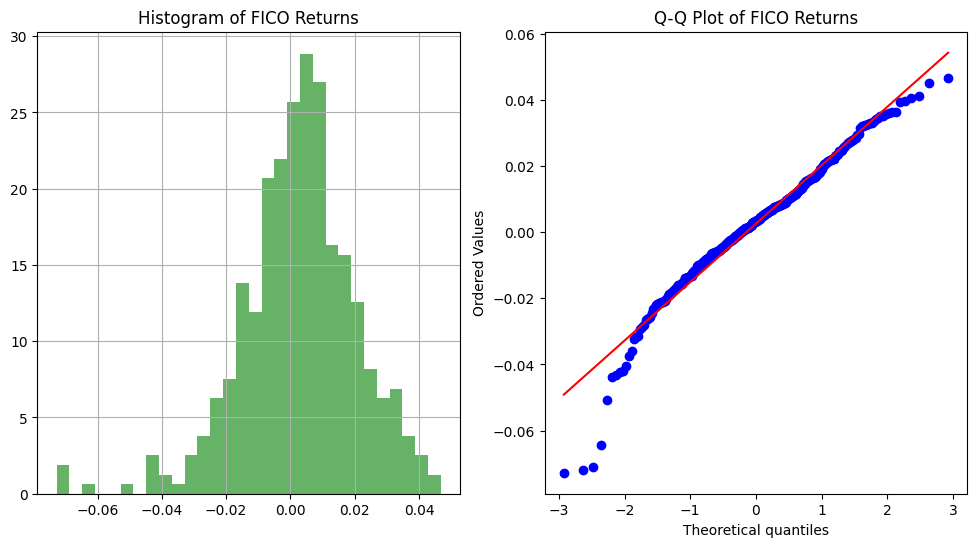

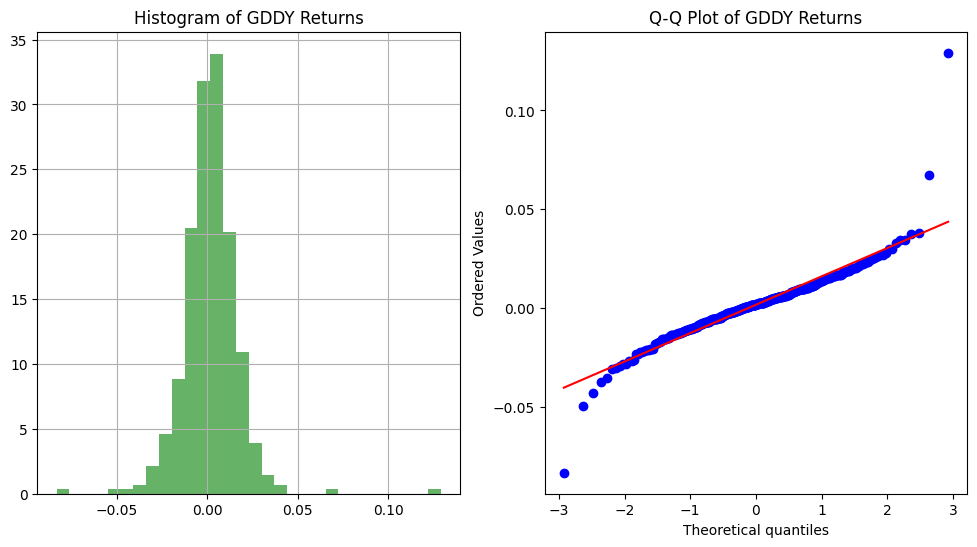

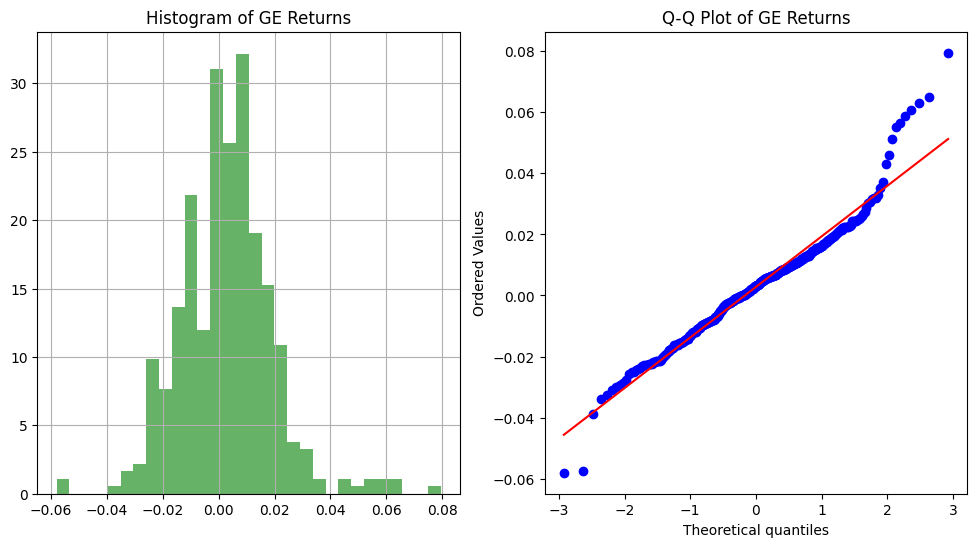

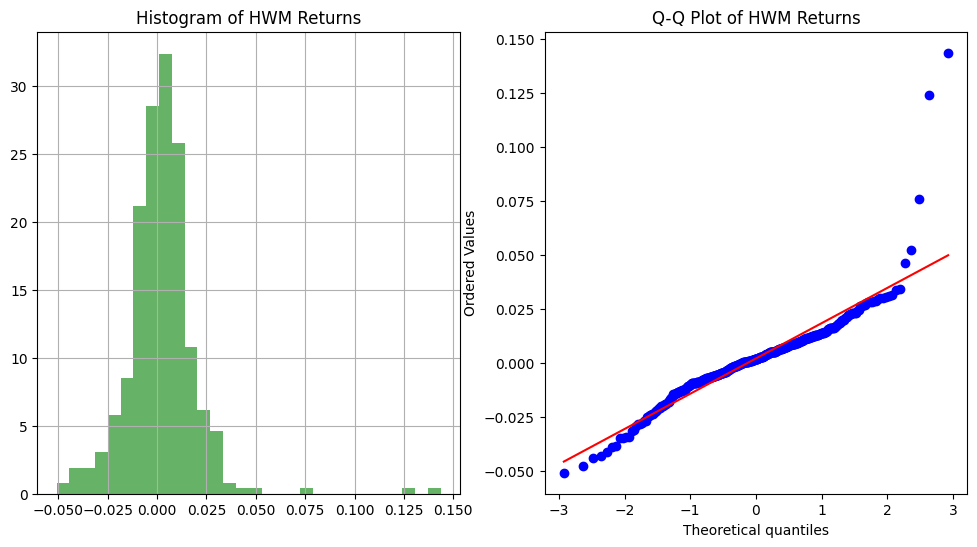

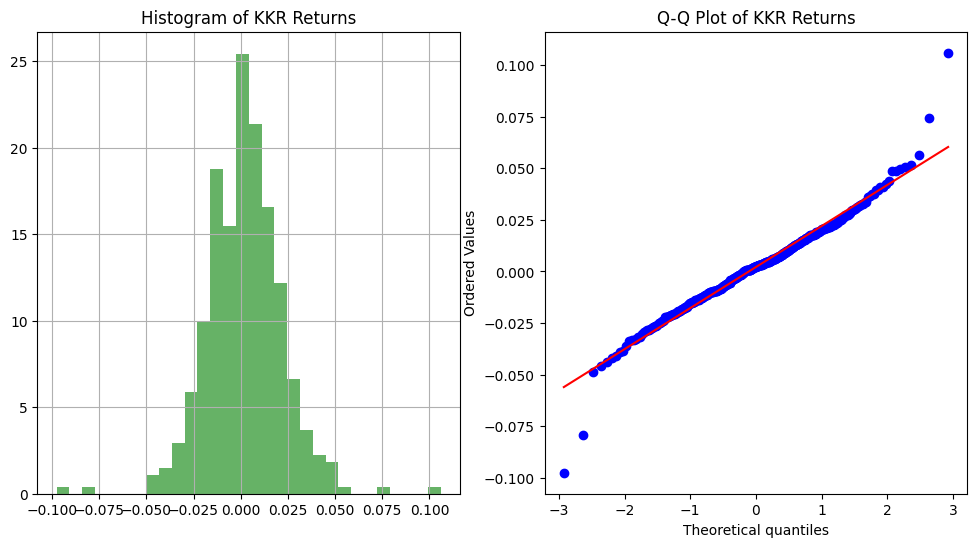

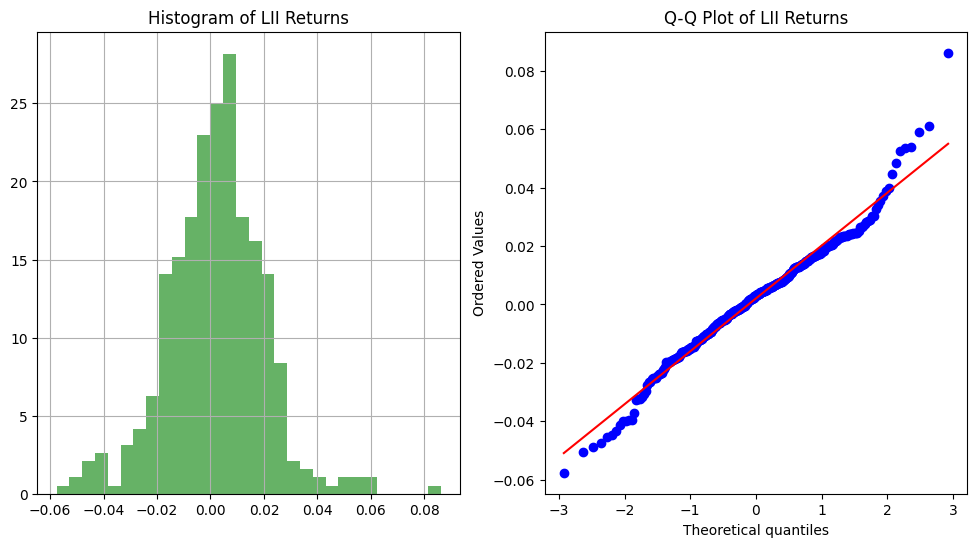

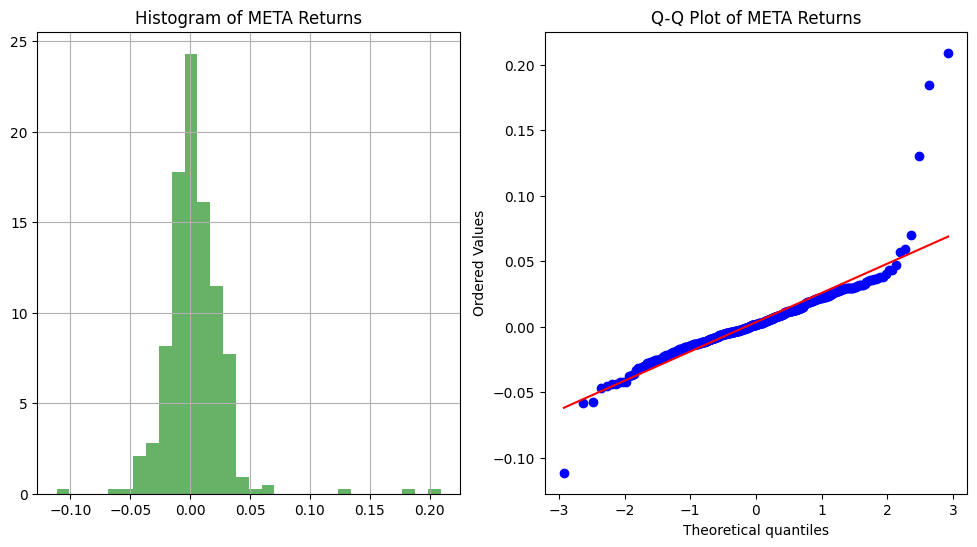

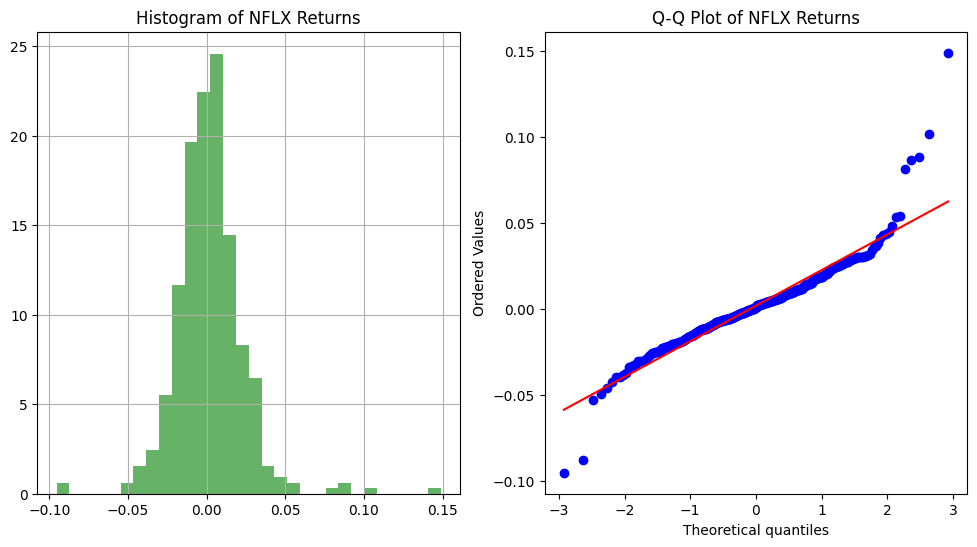

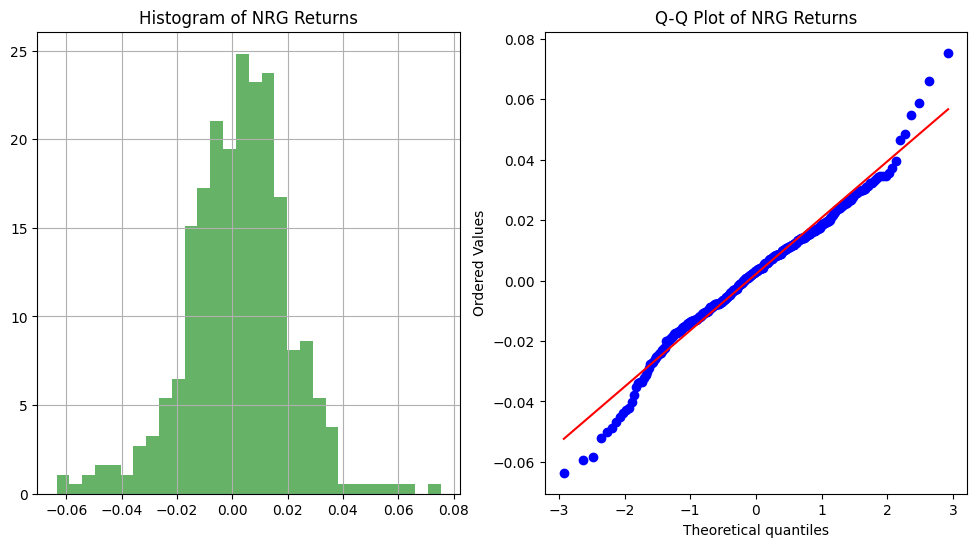

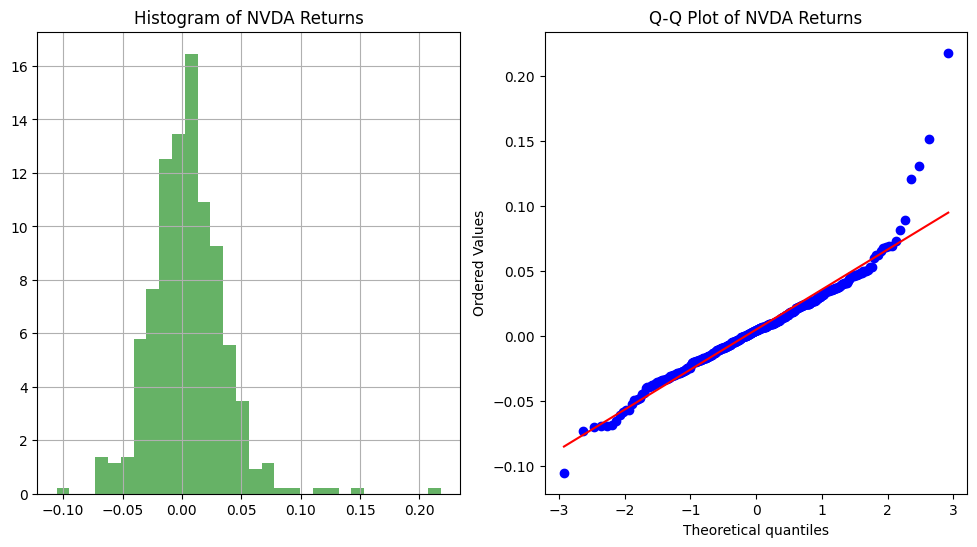

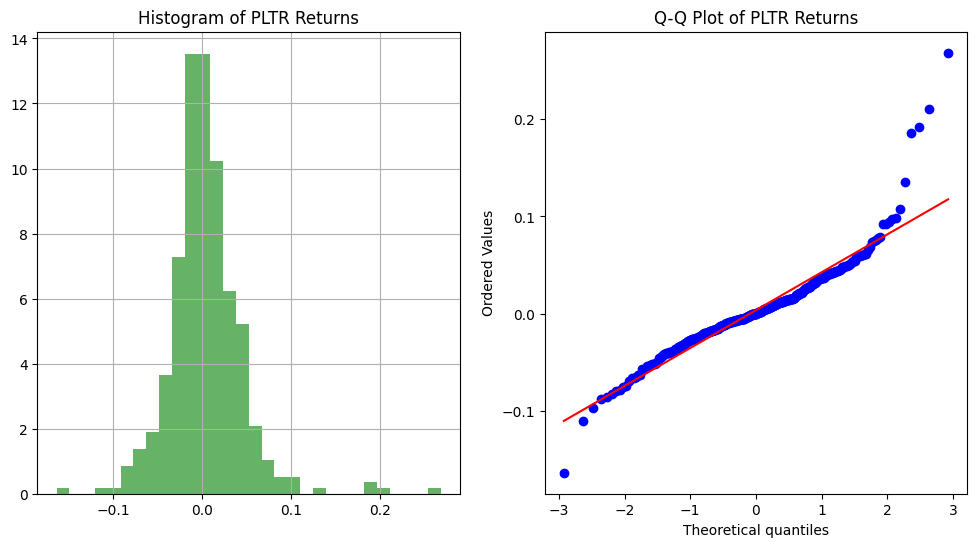

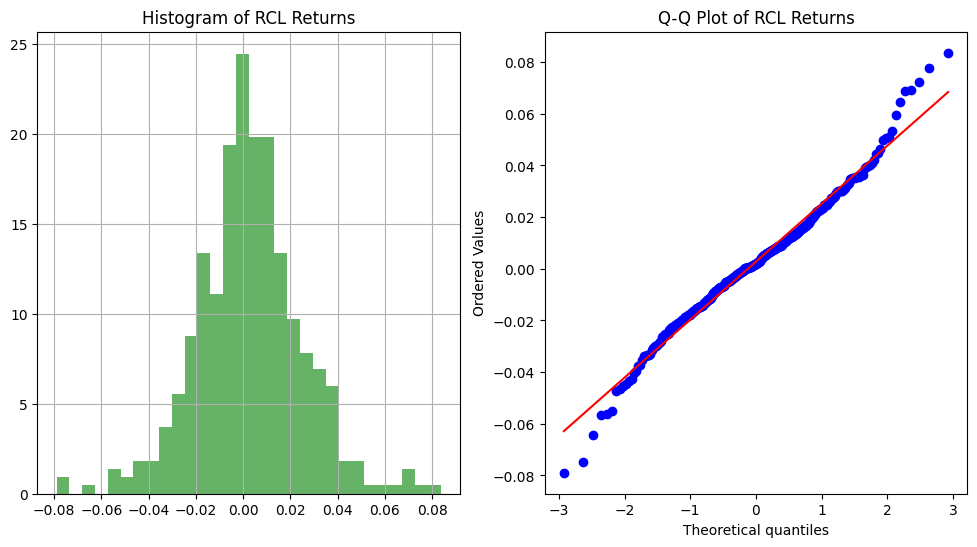

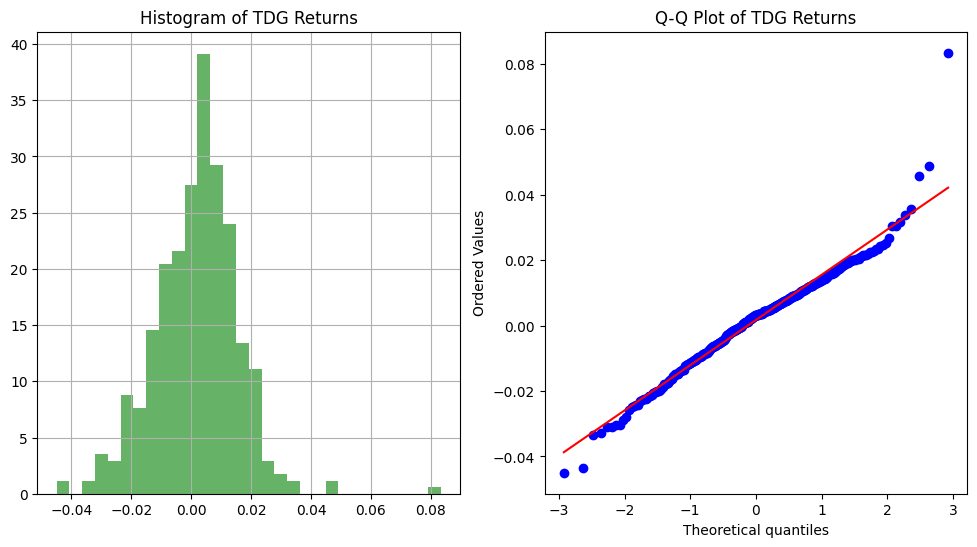

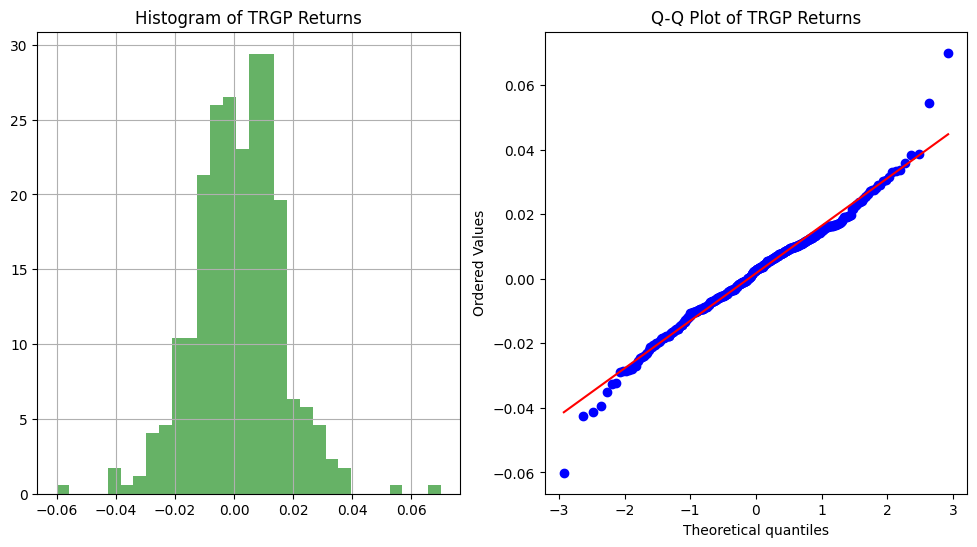

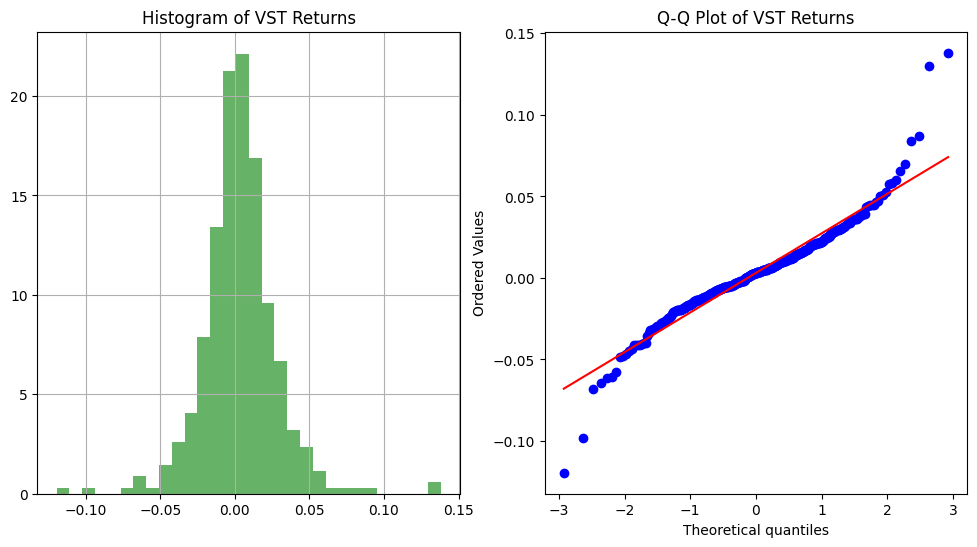

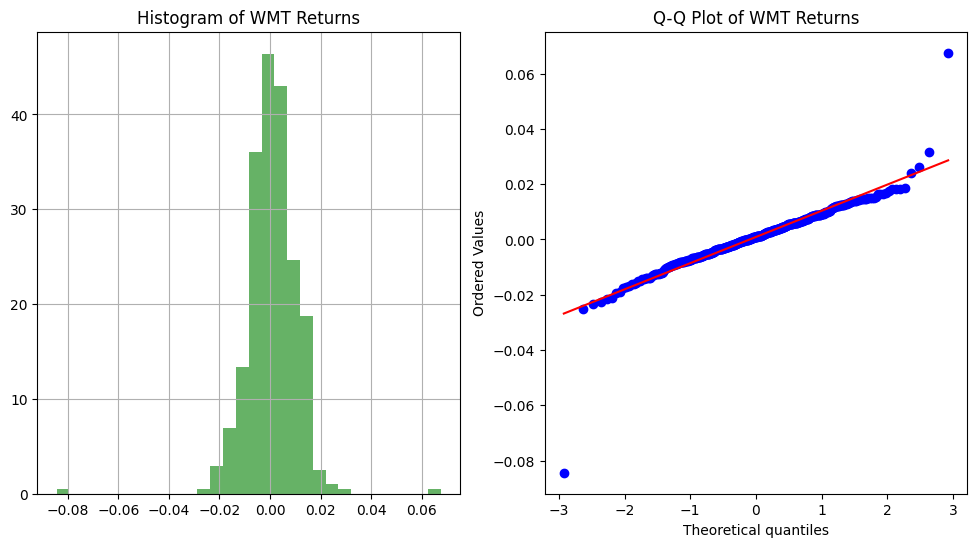

In [ ]:
for ticker in returns_train.columns[:]:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    returns_train[ticker].hist(bins=30, density=True, alpha=0.6, color='g')
    plt.title(f'Histogram of {ticker} Returns')

    plt.subplot(1, 2, 2)
    stats.probplot(returns_train[ticker], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {ticker} Returns')

    plt.show()

In [ ]:
from scipy.stats import kstest

for ticker in returns_train.columns:
    stat, p = kstest(returns_train[ticker], 'norm')
    if p > 0.05:
        print(f'{ticker} returns are normally distributed')
    else:
        print(f'{ticker} returns are not normally distributed')

AVGO returns are not normally distributed
AXON returns are not normally distributed
BKNG returns are not normally distributed
BSX returns are not normally distributed
COST returns are not normally distributed
DECK returns are not normally distributed
FI returns are not normally distributed
FICO returns are not normally distributed
GDDY returns are not normally distributed
GE returns are not normally distributed
HWM returns are not normally distributed
KKR returns are not normally distributed
LII returns are not normally distributed
META returns are not normally distributed
NFLX returns are not normally distributed
NRG returns are not normally distributed
NVDA returns are not normally distributed
PLTR returns are not normally distributed
RCL returns are not normally distributed
TDG returns are not normally distributed
TRGP returns are not normally distributed
VST returns are not normally distributed
WMT returns are not normally distributed


In [ ]:
from scipy.stats import anderson

for ticker in returns_train.columns:
    result = anderson(returns_train[ticker])
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            print(f'{ticker} returns are normally distributed at the {sl}% significance level')
        """
        else:
            print(f'{ticker} returns are not normally distributed at the {sl}% significance level')
        """

# Genetik Algoritma Fonksiyonları

In [13]:
#Config
#max_stocks = 20
max_stocks = num_assets
risk_free_rate = 0.04

In [14]:
def initialize_population(pop_size, num_assets):
    population = []
    np.random.seed(42)
    for _ in range(pop_size):
        weights = dirichlet.rvs(alpha=[1] * num_assets)[0]
        selected_assets = np.random.choice([0, 1], size=num_assets, p=[0.7, 0.3])  # %30 olasılıkla hisse seç
        weights = weights * selected_assets  # Seçilmeyen hisseler 0 olacak
        weights = enforce_constraints(weights)
        population.append(weights)
    return np.array(population)

def enforce_constraints(weights):
    nonzero_indices = np.where(weights > 0)[0]

    # Eğer max_stocks'dan fazla hisse seçilmişse, en büyükleri koru
    if len(nonzero_indices) > max_stocks:
        sorted_indices = np.argsort(weights)[::-1]
        keep_indices = sorted_indices[:max_stocks]
        mask = np.zeros_like(weights)
        mask[keep_indices] = 1
        weights = weights * mask

    # Ağırlıklar %30'u geçemesin
    weights = np.clip(weights, 0, 0.3)

    # Normalize et (Toplam ağırlık = 1)
    if np.sum(weights) > 0:
        weights /= np.sum(weights)

    return weights

def calculate_sharpe(weights, expected_returns, cov_matrix):
    if np.sum(weights) == 0:
        return -np.inf
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
    sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
    return sharpe if portfolio_volatility > 0 else -np.inf

def tournament_selection(population, fitnesses, tournament_size):
    selected = []
    pop_size = len(population)
    for _ in range(pop_size):
        indices = np.random.choice(pop_size, size=tournament_size, replace=False)
        best_idx = indices[np.argmax([fitnesses[i] for i in indices])]
        selected.append(population[best_idx])
    return np.array(selected)

def crossover(parent1, parent2):
    child = (parent1 + parent2) / 2
    child = enforce_constraints(child)
    return child

def mutate(individual):
    idx = np.random.randint(len(individual))
    noise = np.random.uniform(-0.05, 0.05)
    individual[idx] = np.clip(individual[idx] + noise, 0, 0.3)  # bir hissenin ağırlığı %30'u geçemez
    individual = enforce_constraints(individual)
    return individual


In [15]:

#Önceki çalıştırmalarda elde edilen en iyi parametreler
population_size = 304   # Popülasyon büyüklüğü
num_generations = 112    # Nesil sayısı
mutation_rate = 0.058     # Mutasyon olasılığı
selection_size = 2     # Turnuva seleksiyonu boyutu


# Genetik Algoritma ile Statik Portföy Optimizasyonu

In [ ]:
def run_GA(population_size, num_generations, mutation_rate, selection_size):
    population = initialize_population(population_size, num_assets)

    for gen in range(num_generations):

        fitnesses = [calculate_sharpe(ind, expected_returns_train, cov_matrix_train) for ind in population]
        selected = tournament_selection(population, fitnesses, selection_size)

        next_population = []
        for i in range(0, len(selected), 2):
            if i + 1 < len(selected):
                child1 = crossover(selected[i], selected[i + 1])
                child2 = crossover(selected[i + 1], selected[i])
                if np.random.rand() < mutation_rate:
                    child1 = mutate(child1)
                if np.random.rand() < mutation_rate:
                    child2 = mutate(child2)
                next_population.extend([child1, child2])

        population = np.array(next_population)

    fitnesses = [calculate_sharpe(ind, expected_returns_train, cov_matrix_train) for ind in population]
    best_idx = np.argmax(fitnesses)
    best_weights = population[best_idx]

    best_return = np.dot(best_weights, expected_returns_train) * 252  # Yıllık getiri
    best_volatility = np.sqrt(best_weights.T @ cov_matrix_train @ best_weights) * np.sqrt(252)  # Yıllık volatilite
    best_sharpe = (best_return - risk_free_rate) / best_volatility

    return best_sharpe, best_return, best_volatility, best_weights

En iyi parametrelerin bulunması (Çalışması 30dk ya yakın sürmektedir. Daha önceki çalışma sonucu ile devam edilebilir.)

In [ ]:
def evaluate_ga(population_size, num_generations, mutation_rate, selection_size):
    population_size = int(population_size)
    num_generations = int(num_generations)
    selection_size = int(selection_size)
    mutation_rate = float(mutation_rate)

    best_sharpe, best_return, best_volatility, best_weights = run_GA(population_size, num_generations, mutation_rate, selection_size)
    return best_sharpe  # GA'nın döndürdüğü en iyi Sharpe oranı

# Bayes Optimizasyonu için aralıkları belirle
pbounds = {
    "population_size": (100, 800),
    "num_generations": (50, 500),
    "mutation_rate": (0.01, 0.3),
    "selection_size": (2, 10)
}

optimizer = BayesianOptimization(
    f=evaluate_ga,
    pbounds=pbounds,
    random_state=42
)

# Optimizasyonu çalıştır
optimizer.maximize(init_points=10, n_iter=50)

print("En iyi parametreler:", optimizer.max)

In [ ]:
best_params = optimizer.max['params']
population_size = round(best_params['population_size'])
num_generations = round(best_params['num_generations'])
mutation_rate = round(best_params['mutation_rate'],3)
selection_size = round(best_params['selection_size'])
print(f"Population Size: {population_size}")
print(f"Number of Generations: {num_generations}")
print(f"Mutation Rate: {mutation_rate}")
print(f"Selection Size: {selection_size}")

Population Size: 612
Number of Generations: 478
Mutation Rate: 0.119
Selection Size: 7


In [ ]:
def calculate_max_drawdown(log_returns):
    cum_log_returns = pd.Series(log_returns).cumsum()  # Convert to pandas Series
    running_max = cum_log_returns.cummax()
    drawdown = cum_log_returns - running_max
    return drawdown.min()

In [ ]:
best_sharpe, best_return, best_volatility, best_weights = run_GA(population_size, num_generations, mutation_rate, selection_size)

def run_GA_with_metrics():

    print("\nOptimal Portföy Ağırlıkları:")
    portfolio = pd.DataFrame({'Stock': tickers, 'Weight': best_weights})
    portfolio = portfolio[portfolio["Weight"] > 0].sort_values(by="Weight", ascending=False)
    print(portfolio)

    print("\nTrain Optimal Portföy Sonuçları:")
    print(f"Train Sharpe Oranı: {best_sharpe:.4f}")
    print(f"Train Yıllık Getiri: {best_return:.4f}")
    print(f"Train Yıllık Volatilite: {best_volatility:.4f}")
    print(f"Train Maximum Drawdown: {calculate_max_drawdown(returns_train @ best_weights):.4f}")

    return portfolio

portfolio = run_GA_with_metrics()


Optimal Portföy Ağırlıkları:
   Stock    Weight
17  PLTR  0.219282
16  NVDA  0.212912
0   AVGO  0.087675
7   FICO  0.066996
11   KKR  0.046634
21   VST  0.043263
14  NFLX  0.039658
6     FI  0.028187
1   AXON  0.028183
18   RCL  0.028047
13  META  0.025105
5   DECK  0.023349
10   HWM  0.022435
12   LII  0.019180
2   BKNG  0.017472
9     GE  0.017291
20  TRGP  0.016448
8   GDDY  0.014583
15   NRG  0.013670
4   COST  0.010294
3    BSX  0.008257
19   TDG  0.007416
22   WMT  0.003663

Train Optimal Portföy Sonuçları:
Train Sharpe Oranı: 2.5462
Train Yıllık Getiri: 0.7714
Train Yıllık Volatilite: 0.2873
Train Maximum Drawdown: -0.1472


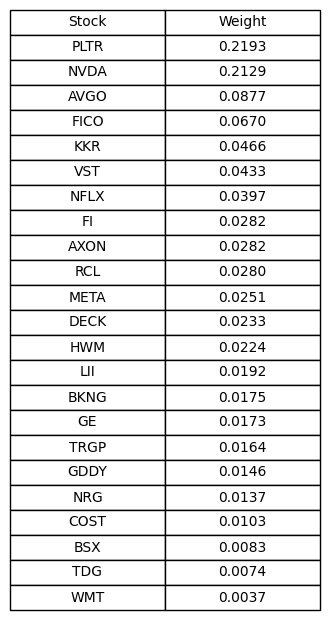

In [ ]:
fig, ax = plt.subplots(figsize=(4, 6))
ax.axis('off')

table_data = [
    [f'{row.Stock}', f'{row.Weight:.4f}'] for _, row in portfolio.iterrows()
]

table = ax.table(
    cellText=table_data,
    colLabels=['Stock', 'Weight'],
    loc='center',
    cellLoc='center',
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.show()


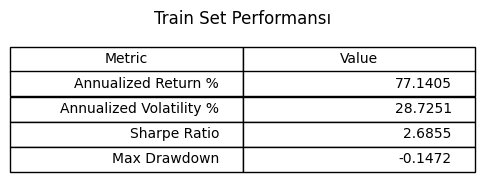

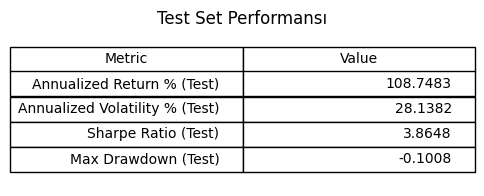

In [ ]:
def annualized_return(daily_returns):
    return daily_returns.mean()*252

# Volatilite Hesaplama
def annualized_volatility(daily_returns):
    return daily_returns.std() * np.sqrt(252)

# Sharpe Oranı Hesaplama
def sharpe_ratio(daily_returns, risk_free_rate=0):
    return (annualized_return(daily_returns) - risk_free_rate) / annualized_volatility(daily_returns)

# Maximum Drawdown Hesaplama
def max_drawdown(daily_returns):
    cum_log_returns = daily_returns.cumsum()
    running_max = cum_log_returns.cummax()
    drawdown = cum_log_returns - running_max
    return drawdown.min()

def portfolio_performance(returns, weights):
    portfolio_returns = (returns * weights).sum(axis=1)
    annual_return = annualized_return(portfolio_returns)
    annual_volatility = annualized_volatility(portfolio_returns)
    sharpe = sharpe_ratio(portfolio_returns)
    max_dd = max_drawdown(portfolio_returns)

    return annual_return, annual_volatility, sharpe, max_dd

def calculate_metrics(train_data, test_data, w_train):
    annual_return_train, annual_volatility_train, sharpe_train, max_dd_train = portfolio_performance(returns_train, w_train)
    expected_returns_test = (returns_test * w_train).sum(axis=1)  # Beklenen test getirisi
    actual_returns_test = returns_test.sum(axis=1)  # Gerçek test getirisi (test verisinden doğrudan)

    # Beklenen ve Gerçek Kazançlar
    expected_profit = expected_returns_test.sum()  # Beklenen kar
    actual_profit = actual_returns_test.sum()  # Gerçek kar

    train_performance_data = {
    'Metric': ['Annualized Return %', 'Annualized Volatility %', 'Sharpe Ratio', 'Max Drawdown'],
    'Value': [round(annual_return_train * 100,4), round(annual_volatility_train * 100,4), round(sharpe_train,4), round(max_dd_train,4)]
    }
    train_performance_df = pd.DataFrame(train_performance_data)

    test_performance_data = {
        'Metric': ['Annualized Return % (Test)', 'Annualized Volatility % (Test)', 'Sharpe Ratio (Test)', 'Max Drawdown (Test)'],
        'Value': [round(annualized_return(expected_returns_test) * 100,4), round(annualized_volatility(expected_returns_test) * 100,4), round(sharpe_ratio(expected_returns_test),4), round(max_drawdown(expected_returns_test),4)]
    }
    test_performance_df = pd.DataFrame(test_performance_data)
    return train_performance_df, test_performance_df

train_performance_df, test_performance_df = calculate_metrics(train, test, best_weights)

plt.figure(figsize=(6, 2))
plt.title('Train Set Performansı')
plt.axis('off')
table = plt.table(cellText=train_performance_df.values, colLabels=train_performance_df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.show()

plt.figure(figsize=(6, 2))
plt.title('Test Set Performansı')
plt.axis('off')
table = plt.table(cellText=test_performance_df.values, colLabels=test_performance_df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

## Sonuçların Görselleştirilmesi

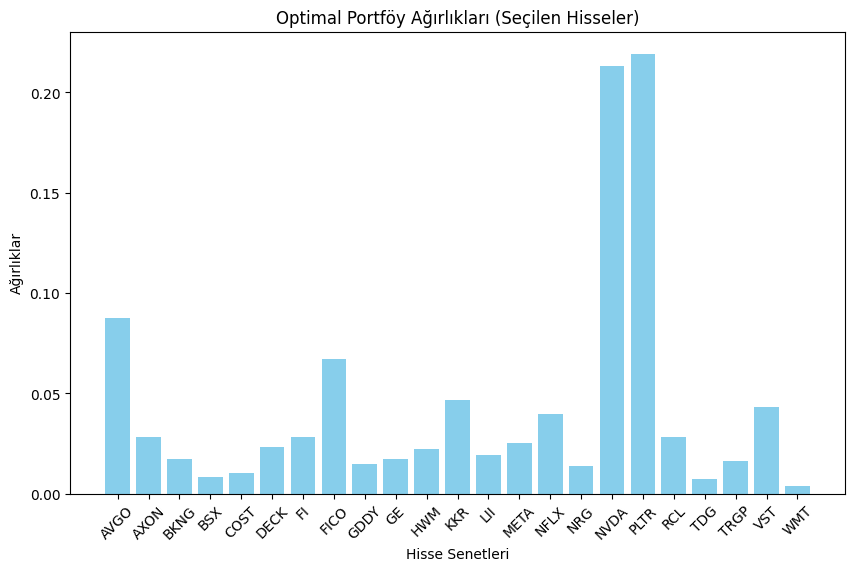

In [ ]:
def plot_portfolio_weights(tickers, weights):
    filtered_tickers = []
    filtered_weights = []
    for ticker, weight in zip(tickers, weights):
        if weight > 0:
            filtered_tickers.append(ticker)
            filtered_weights.append(weight)

    # Grafik çizdir
    plt.figure(figsize=(10, 6))
    plt.bar(filtered_tickers, filtered_weights, color='skyblue')
    plt.xlabel('Hisse Senetleri')
    plt.ylabel('Ağırlıklar')
    plt.title('Optimal Portföy Ağırlıkları (Seçilen Hisseler)')
    plt.xticks(rotation=45)
    plt.show()

plot_portfolio_weights(tickers, best_weights)

In [ ]:
industries = {
    "Industrials": ['AXON', 'GE', 'LII', 'TDG'],
    "Consumer Discretionary": ['BKNG', 'DECK', 'RCL'],
    "Health Care": ['BSX'],
    "Information Technology": ['AVGO', 'FICO', 'GDDY', 'NVDA', 'PLTR'],
    "Consumer Staples": ['COST', 'WMT'],
    "Financials": ['FI', 'KKR'],
    "Communication Services": ['META', 'NFLX'],
    "Utilities": ['NRG', 'VST'],
    "Energy": ['TRGP']
}

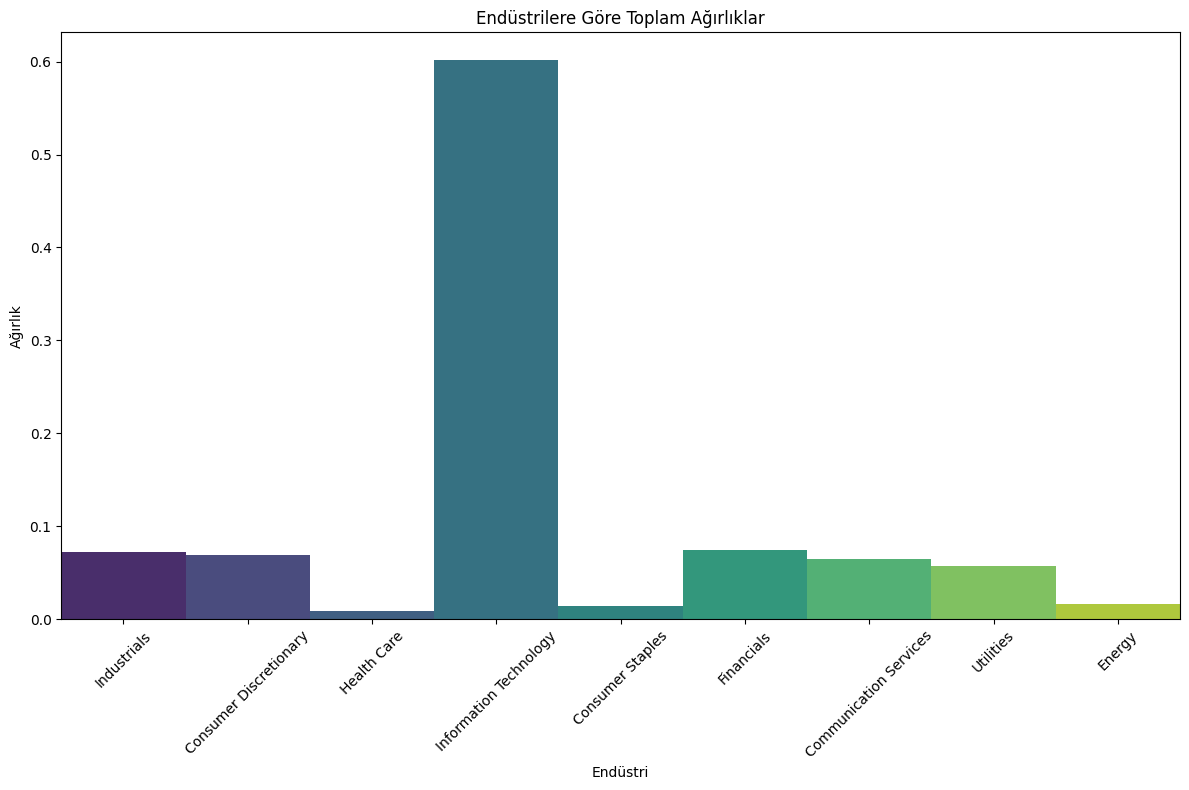

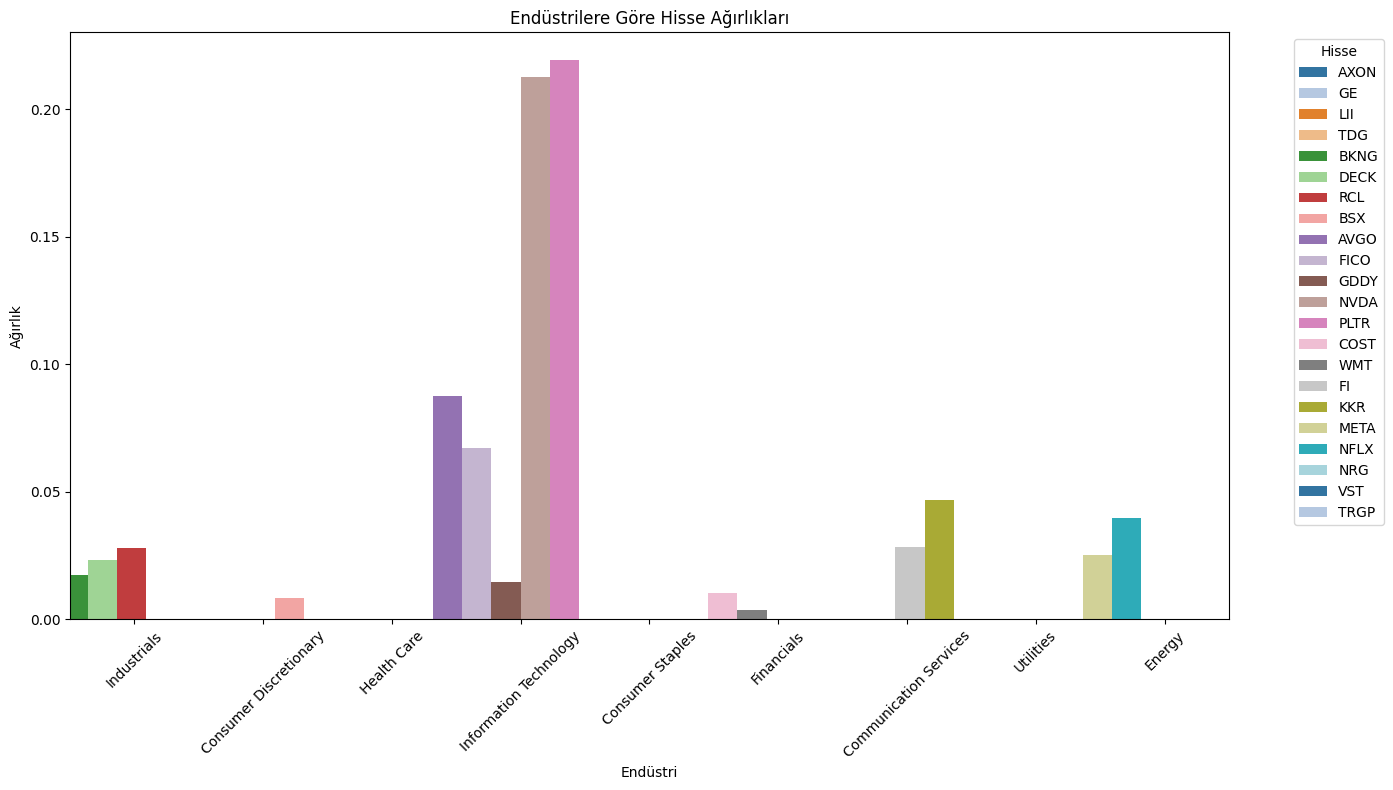

In [ ]:
best_weights_df = pd.DataFrame(portfolio, columns=['Stock', 'Weight'])
best_weights_df['Weight'] = best_weights_df['Weight'].astype(float)
industry_weights = {industry: 0 for industry in industries}

for industry, tickers in industries.items():
    for ticker in tickers:
        weight = best_weights_df.loc[best_weights_df['Stock'] == ticker, 'Weight'].values
        if len(weight) > 0:
            industry_weights[industry] += weight[0]

industry_weights_df = pd.DataFrame.from_dict(industry_weights, orient='index', columns=['Weight']).reset_index()
industry_weights_df.columns = ['Industry', 'Weight']

plt.figure(figsize=(12, 8))
sns.barplot(data=industry_weights_df, x='Industry', y='Weight', palette='viridis', width = 1)
plt.title('Endüstrilere Göre Toplam Ağırlıklar')
plt.xlabel('Endüstri')
plt.ylabel('Ağırlık')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ticker_weights = []
for industry, tickers in industries.items():
    for ticker in tickers:
        weight = best_weights_df.loc[best_weights_df['Stock'] == ticker, 'Weight'].values
        if len(weight) > 0:
            ticker_weights.append({
                'Industry': industry,
                'Ticker': ticker,
                'Weight': weight[0]
            })

ticker_weights_df = pd.DataFrame(ticker_weights)

plt.figure(figsize=(14, 8))
sns.barplot(data=ticker_weights_df, x='Industry', y='Weight', hue='Ticker', dodge=True, palette='tab20', width = 5)
plt.xlabel('Endüstri')
plt.title('Endüstrilere Göre Hisse Ağırlıkları')
plt.xlabel('Endüstri')
plt.ylabel('Ağırlık')
plt.xticks(rotation=45)
plt.legend(title='Hisse', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Target Return Grafiğinin oluşturulması (Target Grafiğinin oluşturulabilmesi için hedef fonksiyonu farklı bir GA oluşturulmakta ve parametrelerinin düzenlenmesi için yeni bir bayesian optimizasyonun çalışması gerekmektedir.) (Daha büyük veri seti burada kullanılmalıdır)


**Sonuçlar Raporda Yer Almaktadır**

In [ ]:
def run_GA_target(population_size, num_generations, mutation_rate, selection_size):
    target_returns = np.linspace(0.3, 0.9, 7)  # farklı hedef getiri
    population = initialize_population(population_size, num_assets)
    results = []

    for target_return in target_returns:
        for gen in range(num_generations):
            fitnesses = [calculate_fitness(ind, expected_returns, cov_matrix, target_return) for ind in population]
            selected = tournament_selection(population, fitnesses, selection_size)

            next_population = []
            for i in range(0, len(selected), 2):
                if i + 1 < len(selected):
                    child1 = crossover(selected[i], selected[i + 1])
                    child2 = crossover(selected[i + 1], selected[i])
                    if np.random.rand() < mutation_rate:
                        child1 = mutate(child1)
                    if np.random.rand() < mutation_rate:
                        child2 = mutate(child2)
                    next_population.extend([child1, child2])

            population = np.array(next_population)

        fitnesses = [calculate_fitness(ind, expected_returns, cov_matrix, target_return) for ind in population]
        best_idx = np.argmax(fitnesses)
        best_weights = population[best_idx]

        best_return = np.dot(best_weights, expected_returns) * 252
        best_volatility = np.sqrt(best_weights.T @ cov_matrix @ best_weights) * np.sqrt(252)
        best_sharpe = (best_return - risk_free_rate) / best_volatility

        results.append({
            'Target Return': target_return,
            'Annualized Return': best_return,
            'Annualized Volatility': best_volatility,
            'Sharpe Ratio': best_sharpe,
            'Weights': best_weights
        })

    return pd.DataFrame(results)

# Optimizasyon fonksiyonu (güncellendi)
def optimize_ga(population_size, num_generations, mutation_rate, selection_size):
    population_size = int(population_size)
    num_generations = int(num_generations)
    selection_size = int(selection_size)

    results_df = run_GA_target(population_size, num_generations, mutation_rate, selection_size)

    # Hedef getiriye yakınlık metriği
    target_return_diff = np.abs(results_df['Target Return'] - results_df['Annualized Return'])
    average_fitness = -target_return_diff.mean()  # Negatif alıyoruz çünkü daha küçük fark, daha iyi

    return average_fitness

# Parametre sınırları
pbounds = {
    'population_size': (100, 1000),
    'num_generations': (50, 500),
    'mutation_rate': (0.01, 0.3),
    'selection_size': (2, 10)
}

# Bayesian Optimizasyonu
optimizer = BayesianOptimization(
    f=optimize_ga,
    pbounds=pbounds,
    random_state=42
)

# Optimizasyonu çalıştır
optimizer.maximize(init_points=5, n_iter=25)

# En iyi parametreleri yazdır
print("En iyi parametreler:", optimizer.max)

# En iyi parametrelerle GA'yı çalıştır
best_params = optimizer.max['params']
population_size = int(best_params['population_size'])
num_generations = int(best_params['num_generations'])
mutation_rate = best_params['mutation_rate']
selection_size = int(best_params['selection_size'])

results_df = run_GA_target(population_size, num_generations, mutation_rate, selection_size)
print(results_df)

In [ ]:
result_df_filtered = results_df.iloc[:, :4]
result_df_filtered = result_df_filtered.round(4)
pd.set_option('display.float_format', '{:.4f}'.format)  # Ondalık sayıları daha düzenli göstermek için
print("\n📊 **Düzenli GA Sonuçları:**\n")
print(result_df_filtered.to_string(index=False))  # İndeks olmadan yazdır
from pandas.plotting import table

fig, ax = plt.subplots(figsize=(10, 4))  # Tablo için boyut
ax.axis('off')  # Eksenleri kapatıyoruz
tbl = table(ax, result_df_filtered, loc='center', colWidths=[0.2]*len(result_df_filtered.columns))

# Tabloyu PNG olarak kaydetme
plt.savefig('ga_results.png', format='png', bbox_inches='tight')

In [ ]:
target_returns = results_df['Target Return'].values
portfolio_weights = np.vstack(results_df['Weights'].values)  # Ağırlıkları düzgün şekilde al

# Hisse sayısını belirtin
num_assets = len(tickers)

# Çizgi Grafiği: Hedef Getiri vs Ağırlıklar
plt.figure(figsize=(10, 6))

# Sadece 0'dan büyük ağırlıkları olanları çizmek
for i in range(num_assets):
    # Hangi hisselerin ağırlığı > 0 (0 olanları filtrele)
    if np.any(portfolio_weights[:, i] > 0):
        plt.plot(target_returns, portfolio_weights[:, i], marker='o', label=tickers[i])

plt.xlabel("Hedef Getiri")
plt.ylabel("Hisse Ağırlıkları")
plt.title("Portföy Ağırlıklarının Hedef Getiriye Göre Değişimi")

# Legend'ı sağ tarafa yerleştirelim
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Hisseler", fontsize=10)

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 📊 Sütun Grafiği: Her hedef getiri için hisse ağırlıkları (Toplam 1 olacak)
fig, ax = plt.subplots(figsize=(12, 6))

# X ekseninde hedef getiri, her sütun bir hissenin ağırlığını gösterir
bar_width = 0.40  # Her bir sütunun genişliği
index = np.arange(len(target_returns))  # X eksenindeki pozisyonlar

# Ağırlıkları sütunlar olarak çizin (üst üste olacak şekilde)
for i in range(num_assets):
    if np.any(portfolio_weights[:, i] > 0):  # Ağırlığı 0 olanları filtrele
        ax.bar(index, portfolio_weights[:, i], bar_width, bottom=np.sum(portfolio_weights[:, :i], axis=1), label=tickers[i])

# Grafik detayları
ax.set_xlabel("Hedef Getiri")
ax.set_ylabel("Portföy Ağırlıkları")
ax.set_title("Portföy Ağırlıklarının Hedef Getiriye Göre Dağılımı (Toplam = 1)")
ax.set_xticks(index)
ax.set_xticklabels([f"{x*100:.0f}%" for x in target_returns], rotation=45)

fig.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Hisseler", fontsize=10)

# Grafik gösterimi
plt.tight_layout()
plt.show()

# Genetik Algoritma ile Dinamik Portföy Optimizasyonu

AIC sonucu bulunan window ve rebalance freq değerleridir. find_best_window.py çalışma sonucundan elde edilmiştir.

In [16]:
#config
window_size = 40
rebalance_freq = 20

In [21]:
def estimate_returns(data, tickers, model_type):
    if model_type == 1:  # Simple mean
        return data.mean(axis=0).values
    elif model_type == 2:  # GARCH
        returns = []
        for t in tickers:
            try:
                model = arch_model(data[t]*100, mean='AR', vol='Garch', p=1, q=1)
                res = model.fit(disp='off')
                returns.append(res.forecast().mean.iloc[-1,0]/100)
            except:
                returns.append(data[t].mean())
        return np.array(returns)

def estimate_volatility_with_garch(train_data, tickers):
    num_assets = len(tickers)
    cov_matrix = np.zeros((num_assets, num_assets))

    # Varyansları GARCH ile tahmin et
    variances = []
    for i, stock in enumerate(tickers):
        try:
            # GARCH modeli (sadece volatilite)
            model = arch_model(train_data[stock], vol='Garch', p=1, q=1)
            garch_fit = model.fit(disp="off")
            forecast = garch_fit.forecast(horizon=1)
            future_vol = np.sqrt(forecast.variance.values[-1, 0])
        except Exception as e:
            future_vol = train_data[stock].std()
        variances.append(future_vol**2)

    # Kovaryansları statik olarak al
    cov_matrix = train_data.cov().values * 252

    # Varyansları GARCH tahminleriyle güncelle
    for i in range(num_assets):
        cov_matrix[i, i] = variances[i]

    return cov_matrix


In [24]:
def genetic_optimizer(expected_returns, cov_matrix, params):
    pop_size = params['population_size']
    num_gen = params['num_generations']
    mutation_rate = params['mutation_rate']
    risk_free_rate = params['risk_free_rate']
    tournament_size = params['selection_size']
    num_assets = len(tickers)

    population = initialize_population(pop_size, num_assets)

    for _ in range(num_gen):
        fitnesses = [calculate_sharpe(w, expected_returns, cov_matrix) for w in population]

        parents = tournament_selection(population, fitnesses, tournament_size)

        next_gen = []
        while len(next_gen) < pop_size:
            p1, p2 = parents[np.random.choice(len(parents), 2, replace=False)]
            child = (p1 + p2) / 2
            if np.random.rand() < mutation_rate:
                child = mutate(child)
            child = enforce_constraints(child)
            next_gen.append(child)

        population = np.array(next_gen)

    # En iyi bireyi seç
    fitnesses = [calculate_sharpe(w, expected_returns, cov_matrix) for w in population]
    return population[np.argmax(fitnesses)]

In [80]:
def portfolio_optimization(returns, tickers, params):
    results = []
    weights_history = []
    actual_returns = []
    predicted_daily_returns = []

    dates = returns.index[params['window_size']::params['rebalance_freq']]

    for i in range(len(dates)-1):
        train_date = dates[i]
        train_data = returns.loc[:train_date].iloc[-params['window_size']:]

        er = estimate_returns(train_data, tickers, params['return_model'])
        cov = train_data.cov().values * 252

        weights = genetic_optimizer(er, cov, params)

        test_data = returns.loc[train_date:dates[i+1]].iloc[1:]

        port_returns = test_data @ weights
        actual_returns.extend(port_returns)

        pred_daily_returns = (er @ weights)
        predicted_daily_returns.append(pred_daily_returns)

        actual_return_annual = np.mean(port_returns) * 252
        predicted_return_annual = np.mean(predicted_daily_returns) * 252

        pred_volatility_annual = weights.T @ cov @ weights
        #pred_volatility_annual = np.sqrt(pred_volatility_annual) * np.sqrt(252)

        actual_volatility_annual = np.std(port_returns) * np.sqrt(252)

        pred_sharpe_annual = (predicted_return_annual - params['risk_free_rate']) / pred_volatility_annual

        actual_sharpe_annual = (actual_return_annual - params['risk_free_rate']) / actual_volatility_annual

        results.append({
            'Date': train_date,
            'Weights': weights.tolist(),
            'Predicted Return': predicted_return_annual,
            'Actual Return': actual_return_annual,
            'Predicted Volatility': pred_volatility_annual,
            'Actual Volatility': actual_volatility_annual,
            'Predicted Sharpe': pred_sharpe_annual,
            'Actual Sharpe': actual_sharpe_annual
        })
        weights_history.append(weights)

    return pd.DataFrame(results), np.array(weights_history), np.array(actual_returns), np.array(predicted_daily_returns)

Predicted Return Annual: 1.6714604733564644
Predicted Return Annual: 0.9309594044329363
Predicted Return Annual: 0.7191310830607363
Predicted Return Annual: 0.9729769862274941
Predicted Return Annual: 1.2088289565393715
Predicted Return Annual: 1.1131857860545151
Predicted Return Annual: 0.9624164409743015
Predicted Return Annual: 0.7905155762102787
Predicted Return Annual: 0.7247322308726428
Predicted Return Annual: 0.7826456647424025
Predicted Return Annual: 0.8297712597590495
Predicted Return Annual: 0.7893213575777124
Predicted Return Annual: 0.8414226540543642
Predicted Return Annual: 0.9001979986701427
Predicted Return Annual: 0.891036013923936
Predicted Return Annual: 0.8771975255216488
Predicted Return Annual: 0.902877171837278
Predicted Return Annual: 0.9034841502246274
Predicted Return Annual: 0.8616189592430156
Predicted Return Annual: 0.7890758301219368
Predicted Return Annual: 0.8293918267418829
Predicted Return Annual: 0.868870646106876
Predicted Return Annual: 0.91545437

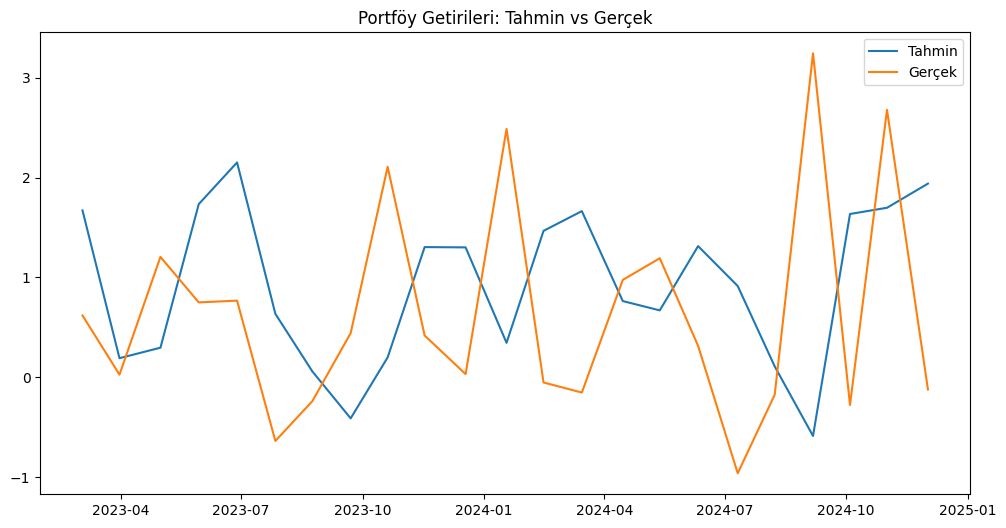

Tahmin Edilen Ortalama Yıllık Getiri: 91.55%
Gerçek Ortalama Yıllık Getiri: 63.62%
Tahmin Edilen Yıllık Volatilite: 4.84%
Gerçek Yıllık Volatilite: 29.09%
Tahmin Edilen Sharpe Oranı: 18.07
Gerçek Sharpe Oranı: 2.05
Tahmin Edilen MaxDD: -0.002338268345946666 
Gerçek MaxDD: -0.1522786256403616 


In [120]:
if __name__ == "__main__":
    data = pd.read_csv('stock_data.csv', index_col='Date', parse_dates=True)
    returns = np.log(data/data.shift(1)).dropna()
    tickers = data.columns.tolist()

    # Parametreler
    params = {
        'window_size': 40,
        'rebalance_freq': 20,
        'return_model': 1,
        'population_size': 304,
        'num_generations': 112,
        'mutation_rate': 0.06,
        'selection_size': 2,
        'risk_free_rate': 0.04
    }

    # Optimizasyonu çalıştır
    results_df, weights_df, actual_returns, predicted_daily_returns = portfolio_optimization(returns, tickers, params)

    # Sonuçları görselleştirme
    plt.figure(figsize=(12,6))
    plt.plot(results_df['Date'], results_df['Predicted Return'], label='Tahmin')
    plt.plot(results_df['Date'], results_df['Actual Return'], label='Gerçek')
    plt.title('Portföy Getirileri: Tahmin vs Gerçek')
    plt.legend()
    plt.show()
    # Günlük getiriler üzerinden performans metrikleri
    annualized_pred_return = np.mean(predicted_daily_returns) * 252
    annualized_actual_return = np.mean(actual_returns) * 252
    annualized_pred_volatility = np.std(predicted_daily_returns) * np.sqrt(252)
    annualized_actual_volatility = np.std(actual_returns) * np.sqrt(252)
    pred_sharpe = (annualized_pred_return - params['risk_free_rate']) / annualized_pred_volatility
    actual_sharpe = (annualized_actual_return - params['risk_free_rate']) / annualized_actual_volatility
    tahmin_maxDD = calculate_max_drawdown(predicted_daily_returns)
    gercek_maxDD = calculate_max_drawdown(actual_returns)

    print(f"Tahmin Edilen Ortalama Yıllık Getiri: {annualized_pred_return:.2%}")
    print(f"Gerçek Ortalama Yıllık Getiri: {annualized_actual_return:.2%}")
    print(f"Tahmin Edilen Yıllık Volatilite: {annualized_pred_volatility:.2%}")
    print(f"Gerçek Yıllık Volatilite: {annualized_actual_volatility:.2%}")
    print(f"Tahmin Edilen Sharpe Oranı: {pred_sharpe:.2f}")
    print(f"Gerçek Sharpe Oranı: {actual_sharpe:.2f}")
    print(f"Tahmin Edilen MaxDD: {tahmin_maxDD} ")
    print(f"Gerçek MaxDD: {gercek_maxDD} ")

Volatilitenin düşük çıkmasının sebebi periyot için hesaplanan beklenen getiri aynı olduğu için periyot içi dalgalanmaların tespit edilememesidir. Önceki dönemlerin varyansı modellenerek tahmin performansı arttırılabilir. (Rapordaki örnek çıktıda yer almaktadır)

In [111]:
mean_metrics = {
    'Ortalama Tahmini Getiri': results_df['Predicted Return'].mean(),
    'Ortalama Gerçekleşen Getiri': results_df['Actual Return'].mean(),
    'Ortalama Tahmini Volatilite': results_df['Predicted Volatility'].mean(),
    'Ortalama Gerçekleşen Volatilite': results_df['Actual Volatility'].mean(),
    'Ortalama Tahmini Sharpe': results_df['Predicted Sharpe'].mean(),
    'Ortalama Gerçekleşen Sharpe': results_df['Actual Sharpe'].mean()
}
mean_metrics_df = pd.DataFrame(mean_metrics, index=[0])
mean_metrics_df

Ortalama Tahmini Getiri  Ortalama Gerçekleşen Getiri  \
0                 0.915454                       0.6362   

   Ortalama Tahmini Volatilite  Ortalama Gerçekleşen Volatilite  \
0                     0.108472                         0.272235   

   Ortalama Tahmini Sharpe  Ortalama Gerçekleşen Sharpe  
0                 9.020607                     2.369557

## Grafikler

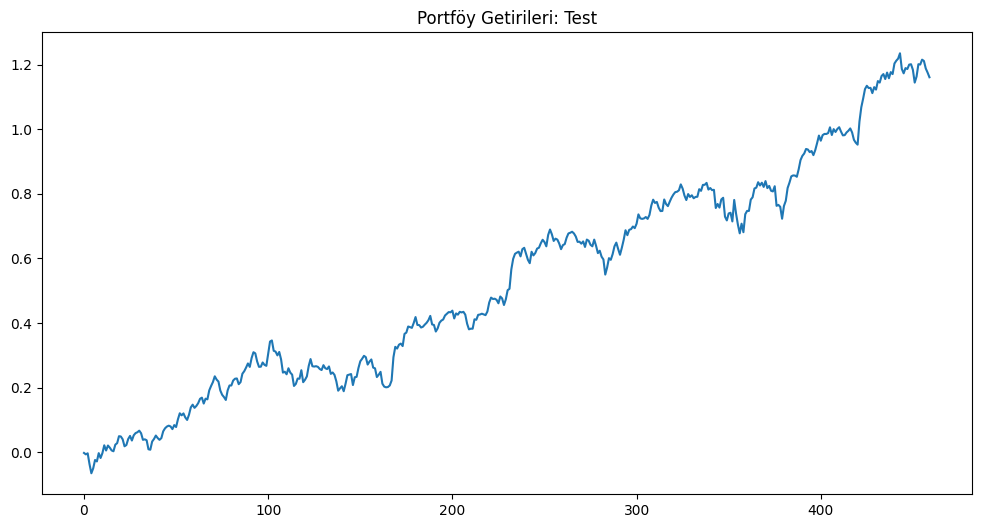

In [92]:
plt.figure(figsize=(12,6))
plt.plot(actual_returns.cumsum())
plt.title('Portföy Getirileri: Test')
plt.show()


-0.1522786256403616


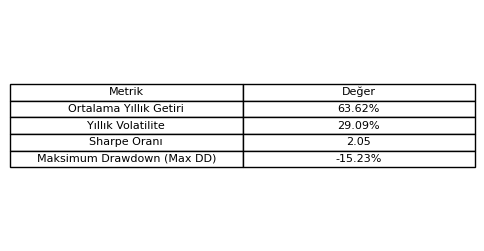

In [121]:
data = {
    'Metrik': ['Ortalama Yıllık Getiri', 'Yıllık Volatilite', 'Sharpe Oranı', 'Maksimum Drawdown (Max DD)'],
    'Değer': [f'{annualized_actual_return*100:.2f}%', f'{annualized_actual_volatility*100:.2f}%', f'{actual_sharpe:.2f}', f'{gercek_maxDD*100:.2f}%']
}
print(gercek_maxDD)
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

plt.show()

In [83]:
results_df

Date                                            Weights  \
0  2023-03-03  [0.04253535226943395, 0.016688892729045134, 0....   
1  2023-03-31  [0.0328987311859067, 0.026279902710535825, 0.0...   
2  2023-05-01  [0.012575077957509685, 0.015055427709379938, 0...   
3  2023-05-30  [0.1076115988530337, 0.011325211234983038, 0.0...   
4  2023-06-28  [0.12442266295504419, 0.0, 0.01750303993345497...   
5  2023-07-27  [0.1294041972531467, 0.019295564131028623, 0.0...   
6  2023-08-24  [0.06923260146327707, 0.0, 0.03508522166143092...   
7  2023-09-22  [0.07232359577188462, 0.01455484562701647, 0.0...   
8  2023-10-20  [0.054047783319792556, 0.09350968069364213, 0....   
9  2023-11-17  [0.05974512744526333, 0.026220658991989353, 0....   
10 2023-12-18  [0.0931649203087929, 0.01757941677474538, 0.03...   
11 2024-01-18  [0.19353419740859631, 0.017188848603057357, 0....   
12 2024-02-15  [0.040187436082138484, 0.02998301556314933, 0....   
13 2024-03-15  [0.09207226400308754, 0.02024394208550091, 0.0...   
14 2024-04-15  [0.18396353933383752, 0.021069139064892828, 0....   
15 2024-05-13  [0.09882317978003094, 0.017019801073186923, 0....   
16 2024-06-11  [0.08141752919292958, 0.01610257026269918, 0.0...   
17 2024-07-11  [0.20005060271159011, 0.011840104225507785, 0....   
18 2024-08-08  [0.2138018385639187, 0.013139020127037725, 0.0...   
19 2024-09-06  [0.21032870161285122, 0.0060607282792652815, 0...   
20 2024-10-04  [0.18004266145331116, 0.021582238230920363, 0....   
21 2024-11-01  [0.12002533202444234, 0.01943445912465628, 0.0...   
22 2024-12-02  [0.0018091071977900373, 0.20990056570168147, 0...   

    Predicted Return  Actual Return  Predicted Volatility  Actual Volatility  \
0           1.671460       0.618595              0.169504           0.274717   
1           0.190458       0.025507              0.124603           0.214198   
2           0.295474       1.205703              0.078176           0.179620   
3           1.734515       0.749523              0.114106           0.239132   
4           2.152237       0.767184              0.121555           0.219070   
5           0.634970      -0.639153              0.058828           0.362967   
6           0.057800      -0.240084              0.103642           0.237363   
7          -0.412790       0.441261              0.098790           0.287720   
8           0.198465       2.108617              0.075456           0.335987   
9           1.303867       0.417304              0.113488           0.195678   
10          1.301027       0.031077              0.091403           0.205286   
11          0.344372       2.488159              0.046842           0.295711   
12          1.466638      -0.052932              0.102807           0.266741   
13          1.664277      -0.153944              0.115261           0.211298   
14          0.762768       0.974886              0.103489           0.317852   
15          0.669620       1.192138              0.094816           0.238123   
16          1.313752       0.314507              0.086949           0.201414   
17          0.913803      -0.963139              0.067401           0.519881   
18          0.108046      -0.175692              0.191388           0.340041   
19         -0.589244       3.246439              0.230640           0.224938   
20          1.635712      -0.278851              0.112738           0.200246   
21          1.697926       2.679745              0.064710           0.350777   
22          1.940296      -0.124251              0.128260           0.342656   

    Predicted Sharpe  Actual Sharpe  
0           9.624897       2.106149  
1           7.150386      -0.067660  
2           8.687239       6.489838  
3           8.176403       2.967075  
4           9.615644       3.319417  
5          18.242665      -1.871115  
6           8.900040      -1.179984  
7           7.597062       1.394626  
8           9.074600       6.156831  
9           6.543799       1.928190  
10          8.640542      -0.043467  

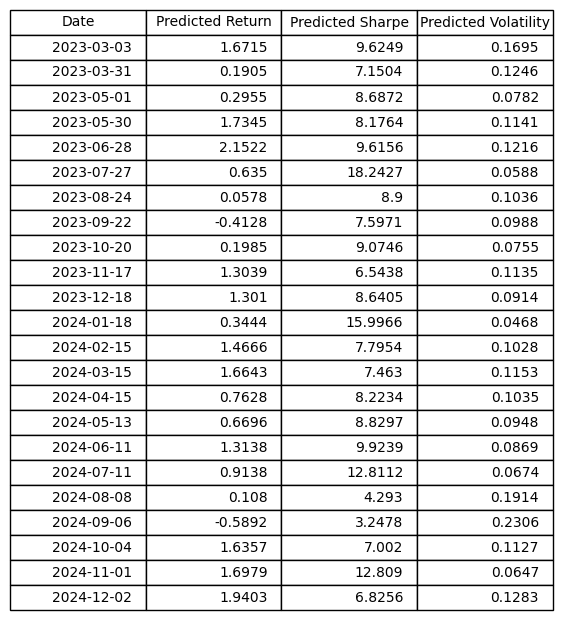

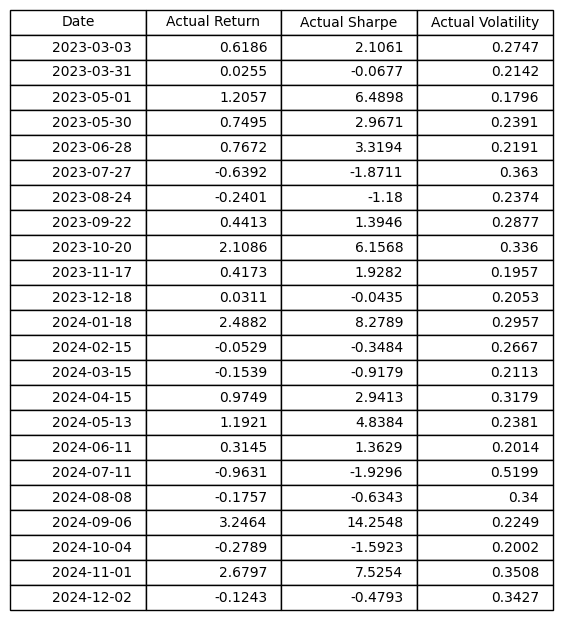

In [93]:

table_data = results_df[['Date', 'Predicted Return', 'Predicted Sharpe', 'Predicted Volatility']].copy()
table_data['Date'] = table_data['Date'].dt.date  # Format date to show only date part
table_data['Predicted Return'] = table_data['Predicted Return'].round(4)
table_data['Predicted Sharpe'] = table_data['Predicted Sharpe'].round(4)
table_data['Predicted Volatility'] = table_data['Predicted Volatility'].round(4)

fig, ax = plt.subplots(figsize=(7, 1))
ax.axis('off')
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)

table.scale(1, 1.5)

plt.show()


table_data = results_df[['Date', 'Actual Return', 'Actual Sharpe', 'Actual Volatility']].copy()
table_data['Date'] = table_data['Date'].dt.date  # Format date to show only date part
table_data['Actual Return'] = table_data['Actual Return'].round(4)
table_data['Actual Sharpe'] = table_data['Actual Sharpe'].round(4)
table_data['Actual Volatility'] = table_data['Actual Volatility'].round(4)

fig, ax = plt.subplots(figsize=(7, 1))
ax.axis('off')
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)

table.scale(1, 1.5)

plt.show()


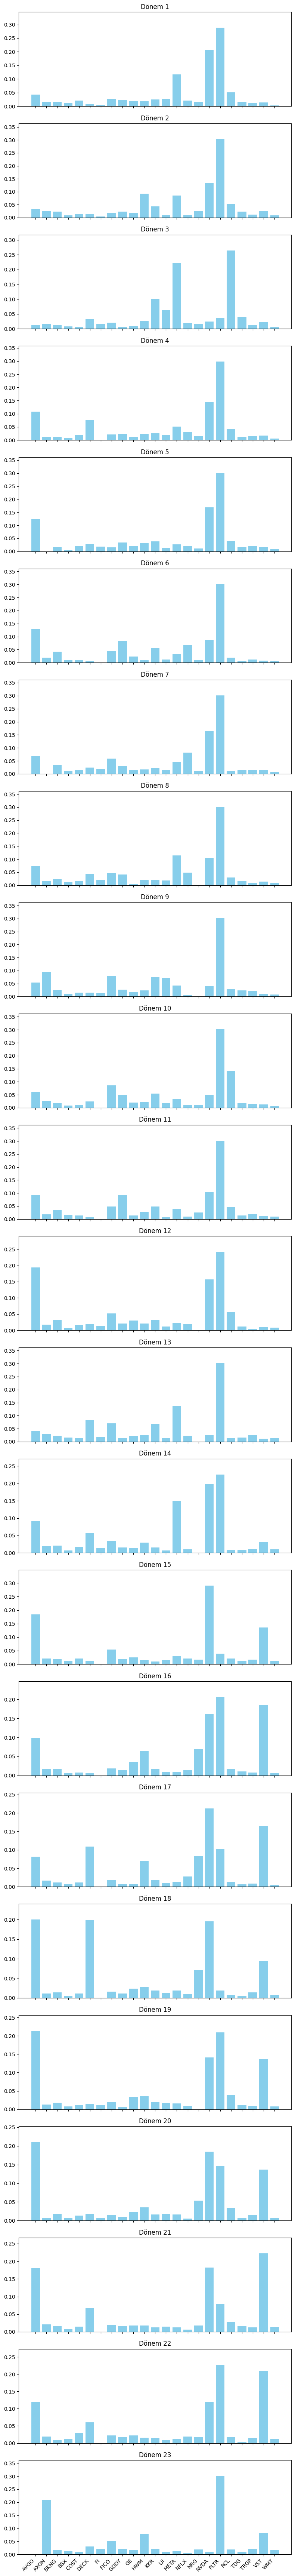

In [95]:
num_periods = len(results_df)
fig, axes = plt.subplots(nrows=num_periods, ncols=1, figsize=(8, num_periods * 3), sharex=True)


if num_periods == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    weights = results_df.iloc[i]['Weights']
    ax.bar(tickers, weights, color='skyblue')
    ax.set_title(f'Dönem {i+1}', fontsize=12)
    ax.set_xticks(range(len(tickers)))
    ax.set_xticklabels(tickers, rotation=45, ha='right', fontsize=10)
    ax.set_ylim(0, max(weights) * 1.2)

plt.tight_layout()
plt.show()

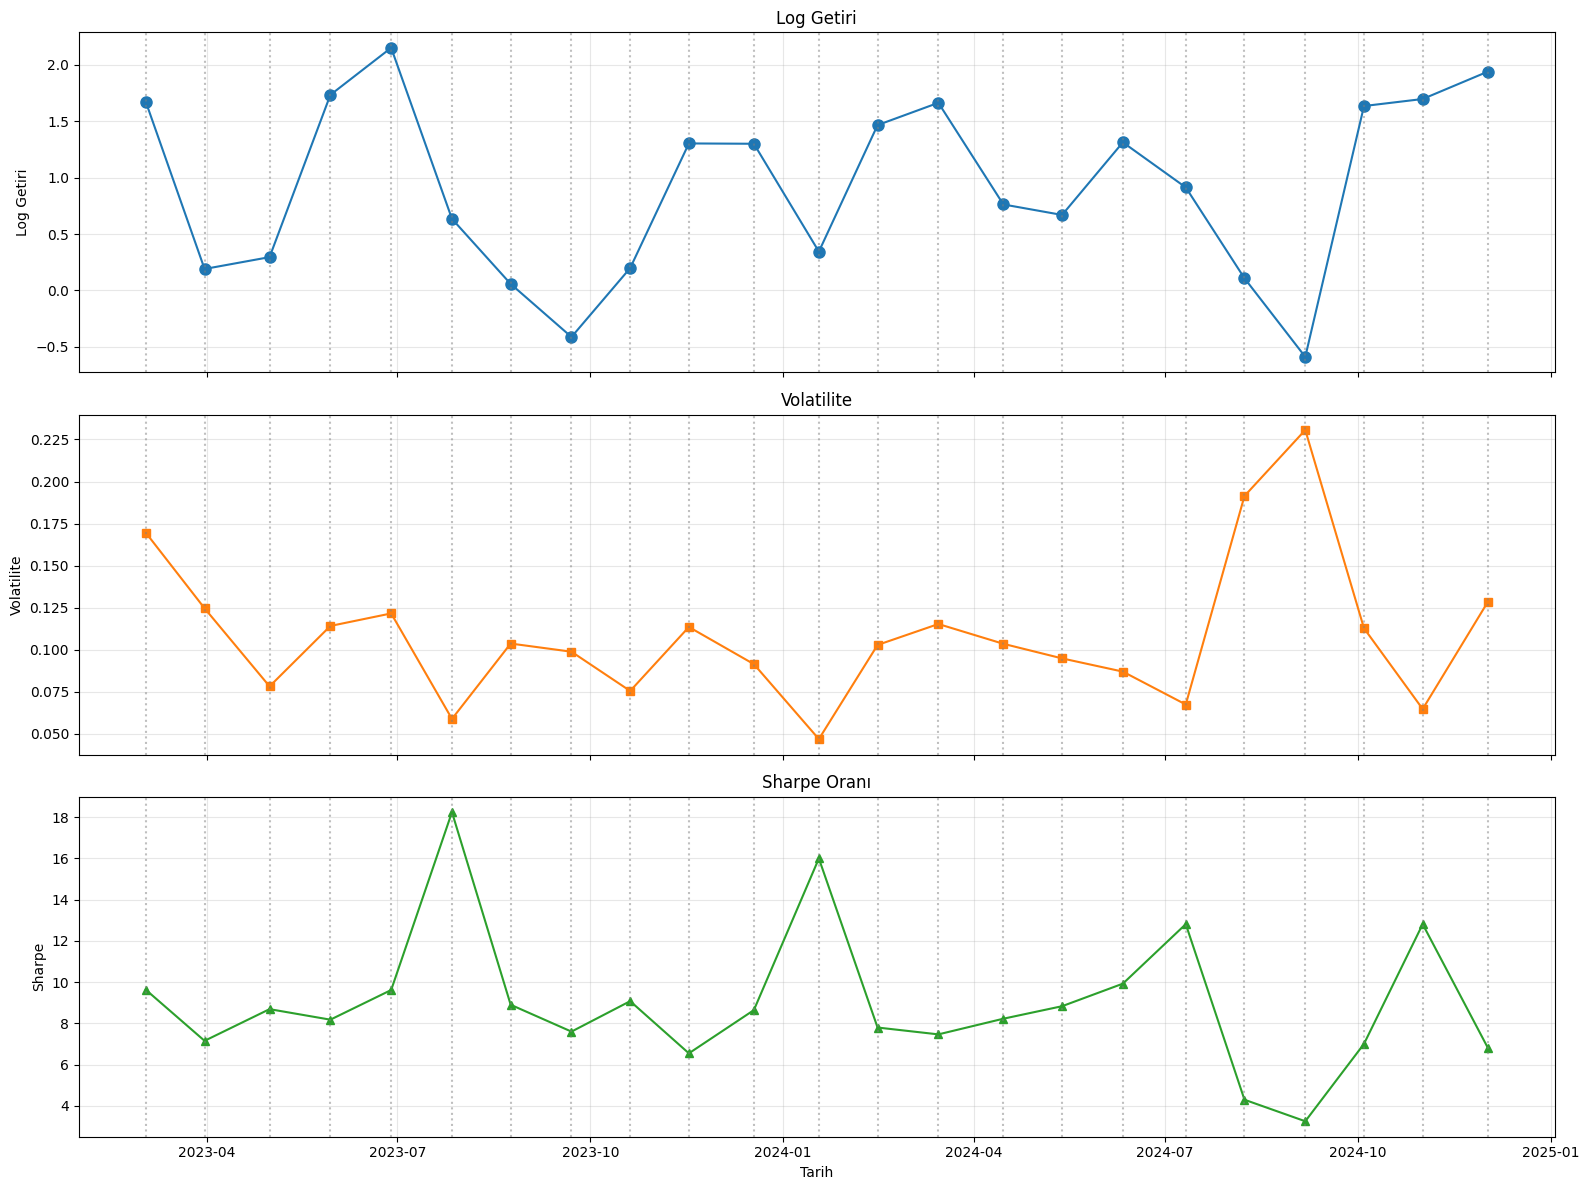

In [100]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

axes[0].plot(results_df['Date'], results_df['Predicted Return'],
            marker='o', linestyle='-', color='#1f77b4', markersize=8)
axes[0].set_title('Log Getiri', fontsize=12)
axes[0].set_ylabel('Log Getiri', fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_df['Date'], results_df['Predicted Volatility'],
            marker='s', linestyle='-', color='#ff7f0e', markersize=6)
axes[1].set_title('Volatilite', fontsize=12)
axes[1].set_ylabel('Volatilite', fontsize=10)
axes[1].grid(True, alpha=0.3)

axes[2].plot(results_df['Date'], results_df['Predicted Sharpe'],
            marker='^', linestyle='-', color='#2ca02c', markersize=6)
axes[2].set_title('Sharpe Oranı', fontsize=12)
axes[2].set_ylabel('Sharpe', fontsize=10)
axes[2].set_xlabel('Tarih', fontsize=10)
axes[2].grid(True, alpha=0.3)

for ax in axes:
    for date in results_df['Date']:
        ax.axvline(x=date, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

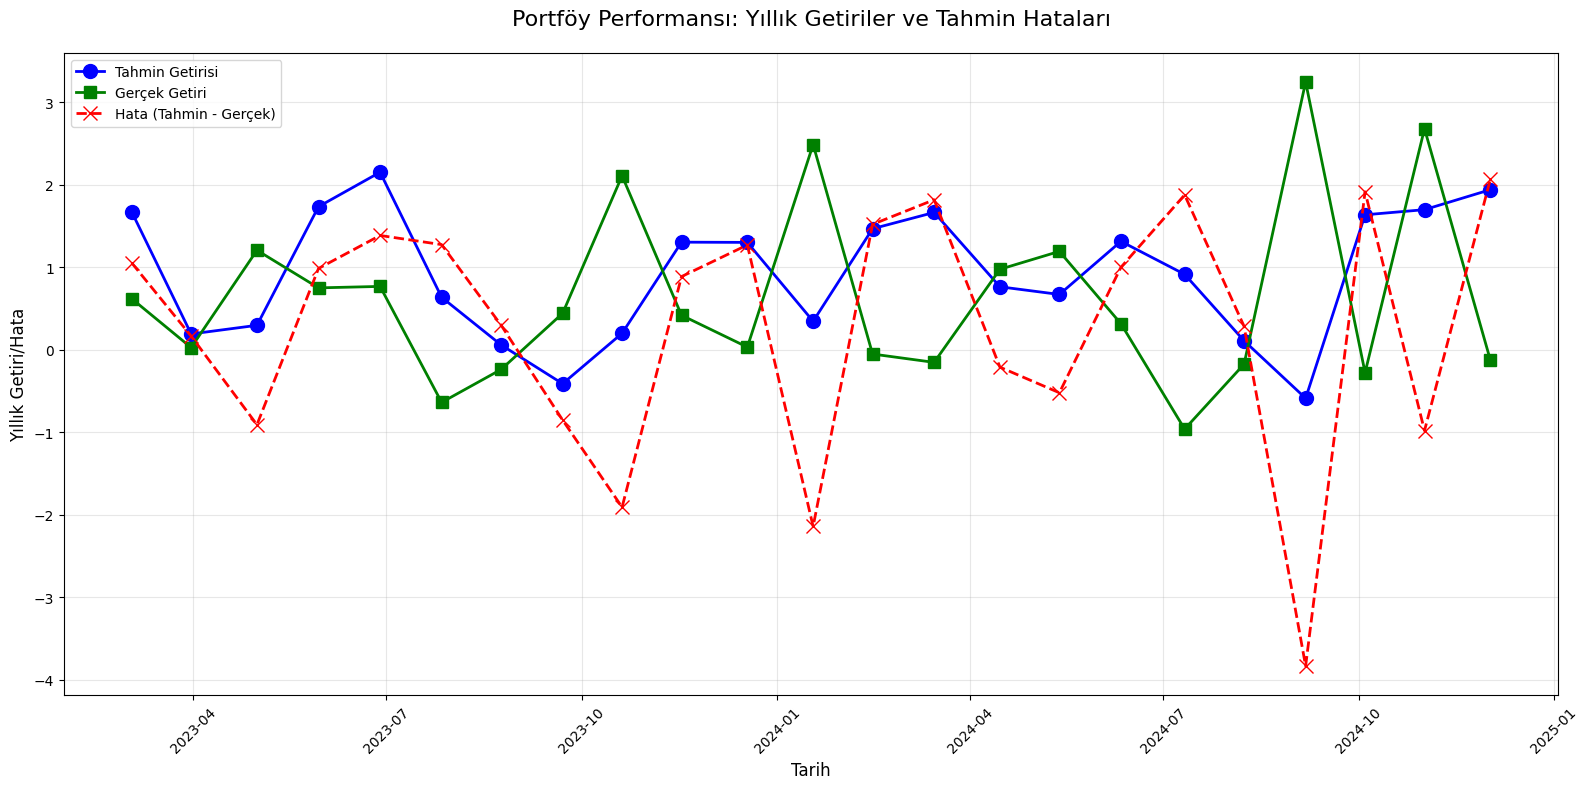

Hata Metrikleri:
MAE: 1.2680
RMSE: 1.5047
MAPE (%): 586.5884%
SMAPE (%): 147.7806%
MASE: 0.9193


In [101]:
def calculate_error_metrics(actual, predicted):
    errors = predicted - actual
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))

    # MAPE (Gerçek değerlerin 0 olmamasına dikkat)
    non_zero_idx = actual != 0
    mape = np.mean(np.abs(errors[non_zero_idx]/actual[non_zero_idx])) * 100

    # SMAPE
    smape = np.mean(2 * np.abs(errors)/(np.abs(predicted) + np.abs(actual))) * 100

    # MASE (Naive seasonal forecast ile)
    naive_forecast_errors = np.abs(np.diff(actual))
    mase = np.mean(np.abs(errors[1:]))/np.mean(naive_forecast_errors)

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'SMAPE (%)': smape,
        'MASE': mase
    }

# Hata metriklerini hesapla
error_metrics = calculate_error_metrics(results_df['Actual Return'], results_df['Predicted Return'])

# Görselleştirme
plt.figure(figsize=(16, 8))
dates = pd.to_datetime(results_df['Date'])

# Ana veriler
plt.plot(dates, results_df['Predicted Return'],
         color='blue',
         marker='o',
         markersize=10,
         linewidth=2,
         label='Tahmin Getirisi')

plt.plot(dates, results_df['Actual Return'],
         color='green',
         marker='s',
         markersize=8,
         linewidth=2,
         label='Gerçek Getiri')

# Hata çizgisi
plt.plot(dates, results_df['Predicted Return'] - results_df['Actual Return'],
         color='red',
         marker='x',
         markersize=10,
         linestyle='--',
         linewidth=2,
         label='Hata (Tahmin - Gerçek)')

# Formatlama
plt.title('Portföy Performansı: Yıllık Getiriler ve Tahmin Hataları', fontsize=16, pad=20)
plt.xlabel('Tarih', fontsize=12)
plt.ylabel('Yıllık Getiri/Hata', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)


plt.legend(loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

# Metrikleri yazdır
print("Hata Metrikleri:")
for metric, value in error_metrics.items():
    print(f"{metric}: {value:.4f}{'%' if '%' in metric else ''}")

# Naive Portfolio

In [ ]:
n = returns_train.shape[1]
weights = np.full(n, 1/n)

portfolio_returns = returns_train.dot(weights)
annual_return = np.mean(portfolio_returns) * 252
annual_volatility = np.std(portfolio_returns) * np.sqrt(252)
sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

cum_log_returns = portfolio_returns.cumsum()
running_max = cum_log_returns.cummax()
drawdown = cum_log_returns - running_max
max_drawdown = drawdown.min()

print(f"Yıllık Getiri: \t\t{annual_return:.2%}")
print(f"Yıllık Volatilite: \t{annual_volatility:.2%}")
print(f"Sharpe Oranı: \t\t{sharpe_ratio:.2f}")
print(f"Maksimum Drawdown: \t{max_drawdown:.2%}")

In [68]:
n = returns_train.shape[1]
weights = np.full(n, 1/n)

portfolio_returns = returns_test.dot(weights)
annual_return = np.mean(portfolio_returns) * 252
annual_volatility = np.std(portfolio_returns) * np.sqrt(252)
sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

cum_log_returns = portfolio_returns.cumsum()
running_max = cum_log_returns.cummax()
drawdown = cum_log_returns - running_max
max_drawdown = drawdown.min()

print(f"Yıllık Getiri: \t\t{annual_return:.2%}")
print(f"Yıllık Volatilite: \t{annual_volatility:.2%}")
print(f"Sharpe Oranı: \t\t{sharpe_ratio:.2f}")
print(f"Maksimum Drawdown: \t{max_drawdown:.2%}")

Yıllık Getiri: 		71.51%
Yıllık Volatilite: 	19.07%
Sharpe Oranı: 		3.54
Maksimum Drawdown: 	-6.18%


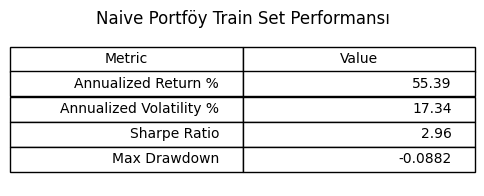

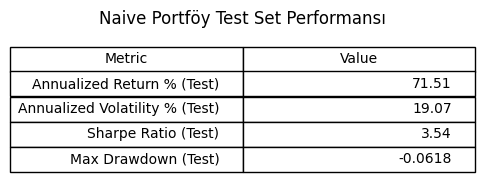

In [69]:
train_performance_data = {
    'Metric': ['Annualized Return %', 'Annualized Volatility %', 'Sharpe Ratio', 'Max Drawdown'],
    'Value': [55.39, 17.34, 2.96, -0.0882]
}
train_performance_df = pd.DataFrame(train_performance_data)

test_performance_data = {
    'Metric': ['Annualized Return % (Test)', 'Annualized Volatility % (Test)', 'Sharpe Ratio (Test)', 'Max Drawdown (Test)'],
    'Value': [71.51, 19.07, 3.54, -0.0618]
}
test_performance_df = pd.DataFrame(test_performance_data)

plt.figure(figsize=(6, 2))
plt.title('Naive Portföy Train Set Performansı')
plt.axis('off')
table = plt.table(cellText=train_performance_df.values, colLabels=train_performance_df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.show()

plt.figure(figsize=(6, 2))
plt.title('Naive Portföy Test Set Performansı')
plt.axis('off')
table = plt.table(cellText=test_performance_df.values, colLabels=test_performance_df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

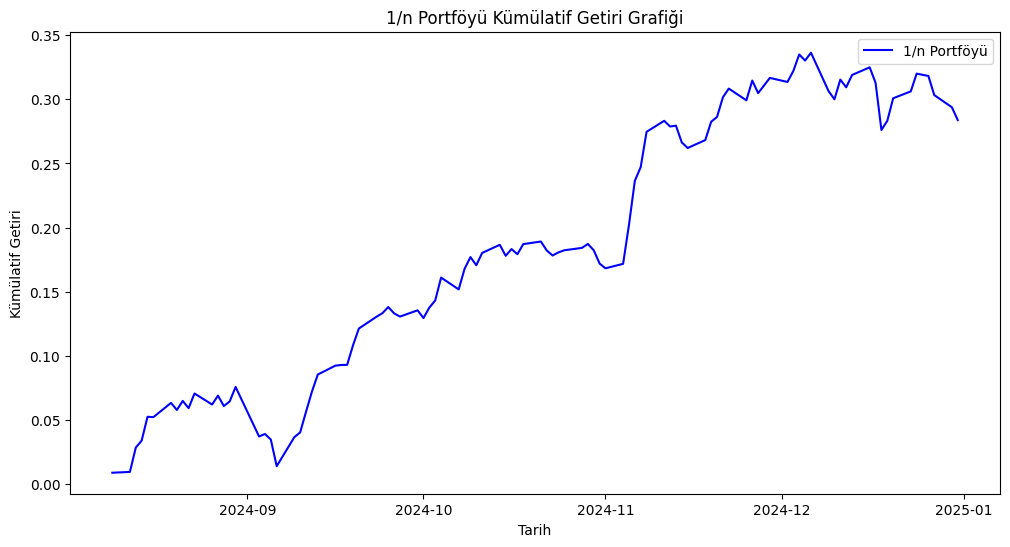

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(cum_log_returns, label="1/n Portföyü", color="blue")
plt.title("1/n Portföyü Kümülatif Getiri Grafiği")
plt.xlabel("Tarih")
plt.ylabel("Kümülatif Getiri")
plt.legend()
plt.show()